# Exploratory Data Analysis of Control Run with Gold standards

In [1]:
using CSV, DataFrames, wgregseq, CairoMakie, Statistics, DelimitedFiles, Dates, Colors, FASTX, BioSequences, StatsBase

wgregseq.plotting_style.default_makie!()
update_theme!(Theme(font = "Lato", titlefont="Lato"))
colors_dict = wgregseq.plotting_style.my_color_dict
colors = [colors_dict["blue1"], colors_dict["orange1"], colors_dict["green1"]]

3-element Vector{String}:
 "#324fa2"
 "#f47c20"
 "#a8cf38"

## Import mapping data

Import the table mapping barcodes to promoter variants and filter out anything that has less than 3 reads, as well as anything with more than 30 mutations.

In [2]:
df_map = CSV.read(
    "../../../data/barcodes/20230322_mapping/mapping_identified.csv", 
    DataFrame, 
    header=["promoter", "barcode", "map_count", "name", "nmut"]
);

df_map = df_map[df_map.name .!= "*", :]

gdf = groupby(df_map[(df_map.map_count .> 2) .& (df_map.nmut .< 30), :], :barcode)
_df = DataFrame()
for df in gdf
    if nrow(df) == 1
        append!(_df, df)
    end
end
df_map = copy(_df);

In [3]:
df_seqs = wgregseq.utils.import_twist_order("../../../data/twist_orders/2022-02-15_twist_order.csv")
df_wt = df_seqs[1:1501:119*1501, :];
insertcols!(df_wt, 4, :promoter_seq => [string(x[27:186]) for x in df_wt.sequence])

df_wt.promoter_seq |> unique |> length

112

## Import barcode data

Import the barcodes for both DNA and RNA and store in tidy dataframe.

In [4]:
df_import = DataFrame()
for ind in ["DP", "DG", "RP88", "RG88", "RP260", "RG260"]
    _df = CSV.read("../../../data/extracted_barcodes/20230327_barcode/$(ind)_collapsed.txt", DataFrame, ignorerepeated=true, delim=" ", header=["ct", "barcode"])
    insertcols!(_df, 1, :source => ind)
    append!(df_import, _df)
end

In [5]:
combine(groupby(df_import, :source), :ct => sum)

Row,source,ct_sum
,String,Int64
1,DP,3355001
2,DG,3003752
3,RP88,4011060
4,RG88,2606317
5,RP260,4711343
6,RG260,2588659


Identify barcodes.

In [6]:
df = innerjoin(df_import, df_map, on=:barcode);

Separate dataframes for each experiment and store in `.csv` files.

In [7]:

p88_df = unstack(df[(df.source .== "DP") .| (df.source .== "RP88"), :], :source, :ct, fill=0)
rename!(p88_df, Dict("DP" => "ct_0", "RP88" => "ct_1"))
insertcols!(p88_df, 1, :ct => p88_df.ct_0 .+ p88_df.ct_1)
#CSV.write("p88_barcodes.csv", p88_df)


p260_df = unstack(df[(df.source .== "DP") .| (df.source .== "RP260"), :], :source, :ct, fill=0)
rename!(p260_df, Dict("DP" => "ct_0", "RP260" => "ct_1"))
insertcols!(p260_df, 1, :ct => p260_df.ct_0 .+ p260_df.ct_1)
#CSV.write("p260_barcodes.csv", p260_df)


g88_df = unstack(df[(df.source .== "DG") .| (df.source .== "RG88"), :], :source, :ct, fill=0)
rename!(g88_df, Dict("DG" => "ct_0", "RG88" => "ct_1"))
insertcols!(g88_df, 1, :ct => g88_df.ct_0 .+ g88_df.ct_1)
#CSV.write("g88_barcodes.csv", g88_df)


g260_df = unstack(df[(df.source .== "DG") .| (df.source .== "RG260"), :], :source, :ct, fill=0)
rename!(g260_df, Dict("DG" => "ct_0", "RG260" => "ct_1"))
insertcols!(g260_df, 1, :ct => g260_df.ct_0 .+ g260_df.ct_1)
#CSV.write("g260_barcodes.csv", g260_df)


Row,ct,barcode,promoter,map_count,name,nmut,ct_0,ct_1
,Int64,String31,String,Int64,String,Int64,Int64,Int64
1,18,CTTCCCTTAAGCCGAGCGCG,TACACATTGATTATTTGCACGGCGTCACACGTTGTTTTGCCATAGCATTTTCACCCATAAGATTAGCGGATCCTACATGTCGCTTTTTATCGCACCTCTCTACGGTTTCTCGAAACCCGTTTGTTTGGATGGAGTTAAACGAGGGCTATTGCAATTGGCC,39,araBp,23,9,9
2,14,TCCTGGCCCCGTACACGTTA,TACACATTGATTATTTGAACGACGTCTCACTTTGCTATGCCATAGCATTTTTATCCATAAGATGAGCGGATCCTACCTGATGCATCCGATCGCAACTCTCTACTGTTGGTCTATACCTGTTTTTGTGGATGGAGTGAAACGATGGCGAGTGCAATTGGCC,39,araBp,25,0,14
3,3,AATTAATACTCAGGGATCTC,TACACATTGATTAATTGCACGACGTCATACTTTGTCATGCCATAGCAATTTAATCCATAATACTCGCGGATCCTACCTGACGCTTTTTATCGCATCTCTGTACTCTTTCTCCATACCCGTTTTTTTGGATGGGGTGAAACGATGGCGATTGCACTTGGCC,39,araBp,23,0,3
4,5,TGTAGGTGATTGTTCAATGT,GTTCATCTTTTTTCAACCATTCAAATCGCACATATACGCCTTTTTTACTGATCACTCAGGCTTTTTTCGATCTTTCTACTTGCATGGTAGTTGCTCAGTTGCGTAGCTTTGATGCATCACGACAAGCGATGCAAGGAATCAAACTTGAAGATCGTAATGG,39,rspAp,22,0,5
5,7,ACGGGGGGTAACTCATTCTC,GTGTTGTAACTCCCCATAGAGCGGCGGATAATGCTGCGATAAGTCGCGTTTTTTTATGTAAAATAATGCCAGCAATAATCGTAATGCATATGGGAAGTGTGATAGTATAACATTTCATGACTACAGCAAGACTAAACTTAACCTGACAAGTCTGGTCTCC,39,znuCp,24,0,7
6,28,CCATTGACTACGCGCAAATC,GTGTTGCACCTCCCCAGAGTGCGGCGGAAAATGGTGCATAAAGAAGCGGTATTTTATGTAACATAATCCGACCAATAATCGGAATGTATATGAGAAGTGTGATATAATAACATTTCCTGACTACTGCAAGTCTATAATCAACATGGCAAGTCTGGTTTCC,39,znuCp,26,0,28
7,10,ACTTCATGGCCGGATCATAC,GTGTTGCACATCCGCGGAGAGCGGCGGATACTGCCGCGAAAAGAAGCGTTTATTGATGTAACACAAAGCGACCAATAATCGTAATGAATATGAGAAGTATGATATTATACCATTTAATGACTACCGTAAGACTAAAATTAACATCACAAGTGTGGTTTCC,39,znuCp,25,0,10
8,3,CGTACTGTGTATAGCCTGTA,GTGTAGCACCTCCCCAGACAACGGTGGATTATGCTGCGAAAAGAAGCGTTTTTTTATGTGACATAAGGCGACCACTTATCGCAATGAATATGAGCAGTGTAATAGTATAACACTTCATGACTACTGCAAGACTAAAATTAACAAGTCAAGTCTGGTTTCC,39,znuCp,24,0,3
9,13,GGTATAGACAGTCCATTATA,GCCCCATTGTTTATTTGCACGGCGTCACAATTTGCGGTGCCATACCATTTTTATTCATAAGATTGGCGGATCCTACCAGACGCTTTTTATCGCAACACTCTACTGTTTCTCCACACCCGTTTTTTTGGATGGAGTGAAAGCATGGCGATTGCAATAGGCT,39,araBp,21,0,13


### Distribution of RNA counts

Percentage of barcodes with no RNA reads: 0.4490208869016707


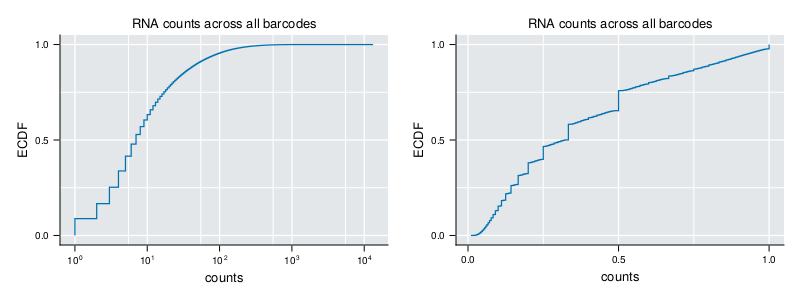

In [8]:

fig = Figure(resolution=(800, 300))
ax = Axis(fig[1, 1], xscale=log10, ylabel="ECDF", xlabel="counts", title="RNA counts across all barcodes")
_df = p88_df[p88_df.ct_1 .> 0, :]

println("Percentage of barcodes with no RNA reads: ", nrow(_df) / nrow(p88_df))

lines!(ax, sort(_df.ct_1), 1/nrow(_df):1/nrow(_df):1)

ax = Axis(fig[1, 2], ylabel="ECDF", xlabel="counts", title="RNA counts across all barcodes")
lines!(ax, sort((p88_df.ct_1 .+1) ./ (1 .+ p88_df.ct)), 1/nrow(p88_df):1/nrow(p88_df):1)
fig



## Number of Barcodes per promoter variant

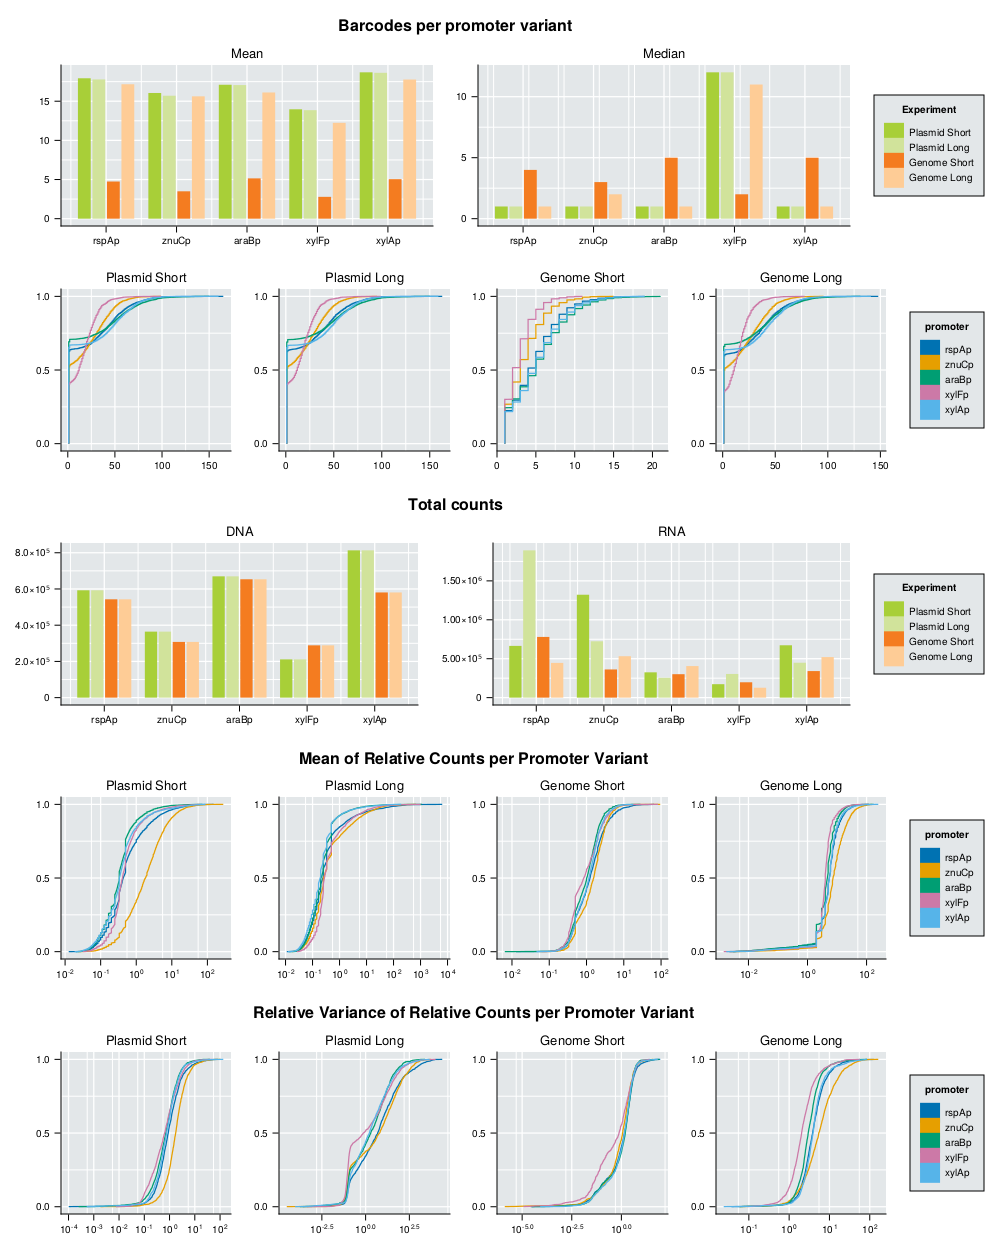

In [9]:
# Dictionary for promoter to integers 
D = enumerate(["rspAp", "znuCp", "araBp", "xylFp", "xylAp"]) |> collect |> Dict 
D = Dict(D[k] => k for k in keys(D))
color_bars = [colors_dict["green1"], colors_dict["green2"], colors_dict["orange1"], colors_dict["orange2"]]
color_prom = Makie.wong_colors()

# DataFrame to plot summary statistics
plot_df_sum = DataFrame()

# DataFrame to plot ECDFS
plot_df_ecdf = DataFrame()

# DataFrame to plot counts
plot_df_counts = DataFrame()

function compute_ratio(x, y)
    if length(x) < 2
        return 0
    else
        return var((y .+ 1) ./ (x .+ 1)) / mean((y .+ 1) ./ (x .+ 1))
    end
end


# Iterate through DataFrames
for (i, (df, lab))  in enumerate(zip([p88_df, p260_df, g88_df, g260_df], ["Plasmid Short", "Plasmid Long", "Genome Short", "Genome Long"]))
    # Only keep gold standards
    _df  = df[map(x -> x ∈ ["rspAp", "znuCp", "araBp", "xylFp", "xylAp"], df.name), :]

    # Compute number of barcodes per promoter variant
    cdf = combine(
        groupby(
            _df, 
            [:promoter, :name]
            ), 
            [:ct_0, :ct_1] => ((x, y) -> (
                nrow=length(x), 
                mean_ratio=mean((y .+ 1) ./ (x .+ 1)), 
                var_ratio=compute_ratio(x, y)
            )
        ) => AsTable
    )

    # Compute mean and median
    cdf_sum = combine(groupby(cdf, :name), [:nrow] => ((x) -> (mean_nrow=mean(x), median_nrow=median(x))) => AsTable)

    # Compute number of barcodes per promoter variant
    cdf_counts = combine(groupby(_df, [:name]), [:ct_0, :ct_1] => ((x, y) -> (total_ct0=sum(x), total_ct1=sum(y))) => AsTable)

    # Add integers for plotting
    insertcols!(cdf, 1, :source => lab)
    insertcols!(cdf_sum, 1, :source => lab)
    insertcols!(cdf_counts, 1, :source => lab)

    insertcols!(cdf, 1, :source_ind => i)
    insertcols!(cdf_sum, 1, :source_ind => i)
    insertcols!(cdf_counts, 1, :source_ind => i)

    # Append DataFrames
    append!(plot_df_sum, cdf_sum)
    append!(plot_df_ecdf, cdf)
    append!(plot_df_counts, cdf_counts)
end

# Add integer for promoter variants
insertcols!(plot_df_sum, 1, :promoter_ind => [D[x] for x in plot_df_sum.name])
insertcols!(plot_df_ecdf, 1, :promoter_ind => [D[x] for x in plot_df_ecdf.name])
insertcols!(plot_df_counts, 1, :promoter_ind => [D[x] for x in plot_df_counts.name])

# Start figure
fig = Figure(resolution=(1000, 1250))

# Figure elements
g1 = fig[1, 1] = GridLayout()
g2 = fig[2, 1] = GridLayout()
g3 = fig[3, 1] = GridLayout()
g4 = fig[4, 1] = GridLayout()
g5 = fig[5, 1] = GridLayout()

## Barcode summary 
ax = Axis(g1[1, 1], xticks=(1:5, ["rspAp", "znuCp", "araBp", "xylFp", "xylAp"]), title="Mean")

barplot!(
    ax, 
    plot_df_sum.promoter_ind, 
    plot_df_sum.mean_nrow, 
    dodge=plot_df_sum.source_ind,  
    color = color_bars[plot_df_sum.source_ind]
)

ax2 = Axis(g1[1, 2], xticks=(1:5, ["rspAp", "znuCp", "araBp", "xylFp", "xylAp"]), title="Median")
barplot!(
    ax2, 
    plot_df_sum.promoter_ind, 
    plot_df_sum.median_nrow, 
    dodge=plot_df_sum.source_ind,  
    color = color_bars[plot_df_sum.source_ind]
)

# Legend
labels = ["Plasmid Short", "Plasmid Long", "Genome Short", "Genome Long"]
elements = [PolyElement(polycolor = color_bars[i]) for i in 1:length(labels)]
title = "Experiment"

Legend(g1[1,3], elements, labels, title)


# ECDF of number of barcodes per promoter variant
for (i, source) in enumerate(["Plasmid Short", "Plasmid Long", "Genome Short", "Genome Long"])
    ax3 = Axis(g2[1, i], title=source)
    for prom in ["rspAp", "znuCp", "araBp", "xylFp", "xylAp"]
        _df = plot_df_ecdf[(plot_df_ecdf.name .== prom) .& (plot_df_ecdf.source .== source), :]
        lines!(ax3, sort(_df.nrow), 1/nrow(_df):1/nrow(_df):1)
    end
end

# Legend
labels = ["rspAp", "znuCp", "araBp", "xylFp", "xylAp"]
elements = [PolyElement(polycolor = color_prom[i]) for i in 1:length(labels)]
title = "promoter"

Legend(g2[1,5], elements, labels, title)


## Summary of counts per promoter 
# DNA counts
ax = Axis(g3[1, 1], xticks=(1:5, ["rspAp", "znuCp", "araBp", "xylFp", "xylAp"]), title="DNA")
barplot!(
    ax, 
    plot_df_counts.promoter_ind, 
    plot_df_counts.total_ct0, 
    dodge=plot_df_counts.source_ind,  
    color = color_bars[plot_df_counts.source_ind]
)

# RNA counts
ax2 = Axis(g3[1, 2], xticks=(1:5, ["rspAp", "znuCp", "araBp", "xylFp", "xylAp"]), title="RNA")
barplot!(
    ax2, 
    plot_df_counts.promoter_ind, 
    plot_df_counts.total_ct1, 
    dodge=plot_df_counts.source_ind,  
    color = color_bars[plot_df_counts.source_ind]
)

# Legend
labels = ["Plasmid Short", "Plasmid Long", "Genome Short", "Genome Long"]
elements = [PolyElement(polycolor = color_bars[i]) for i in 1:length(labels)]
title = "Experiment"

Legend(g3[1,3], elements, labels, title)



for (i, source) in enumerate(["Plasmid Short", "Plasmid Long", "Genome Short", "Genome Long"])
    ax3 = Axis(g4[1, i], title=source, xscale=log10)
    for prom in ["rspAp", "znuCp", "araBp", "xylFp", "xylAp"]
        _df = plot_df_ecdf[(plot_df_ecdf.name .== prom) .& (plot_df_ecdf.source .== source), :]
        lines!(ax3, sort(_df.mean_ratio), 1/nrow(_df):1/nrow(_df):1)
    end
end

for (i, source) in enumerate(["Plasmid Short", "Plasmid Long", "Genome Short", "Genome Long"])
    ax3 = Axis(g5[1, i], title=source, xscale=log10)
    for prom in ["rspAp", "znuCp", "araBp", "xylFp", "xylAp"]
        _df = plot_df_ecdf[(plot_df_ecdf.name .== prom) .& (plot_df_ecdf.source .== source).& (plot_df_ecdf.var_ratio .> 0), :]
        lines!(ax3, sort(_df.var_ratio), 1/nrow(_df):1/nrow(_df):1)
    end
end


# Legend
labels = ["rspAp", "znuCp", "araBp", "xylFp", "xylAp"]
elements = [PolyElement(polycolor = color_prom[i]) for i in 1:length(labels)]
title = "promoter"

Legend(g4[1,5], elements, labels, title)
Legend(g5[1,5], elements, labels, title)

# Section off plot
Label(g1[1, 1:2, Top()], "Barcodes per promoter variant", valign = :bottom, font = :bold, padding = (0, 0, 30, 0))
Label(g3[1, 1:2, Top()], "Total counts", valign = :bottom, font = :bold, padding = (0, 0, 30, 0))
Label(g4[1, 1:4, Top()], "Mean of Relative Counts per Promoter Variant", valign = :bottom, font = :bold, padding = (0, 0, 30, 0))
Label(g5[1, 1:4, Top()], "Relative Variance of Relative Counts per Promoter Variant", valign = :bottom, font = :bold, padding = (0, 0, 30, 0))

fig

In [10]:
gcs =  ["Plasmid Short", "Plasmid Long", "Genome Short", "Genome Long"]


fig_list=[]

df_list = [p88_df, p260_df, g88_df, g260_df]

highlight = "rspAp"

for j in 1:length(gcs)
    for i in j+1:length(gcs)
        fig = Figure(resolution=(1200, 300))
        ax_DNA = Axis(fig[1, 1], yscale=log10, xscale=log10)
        ax_RNA = Axis(fig[1, 2], yscale=log10, xscale=log10)
        ax_rel = Axis(fig[1, 3], yscale=log10, xscale=log10)

        ax_DNA.xlabel = gcs[j]
        ax_DNA.ylabel = gcs[i]
        ax_DNA.title = "gDNA"
        
        ax_RNA.xlabel = gcs[j]
        ax_RNA.ylabel = gcs[i]
        ax_RNA.title = "cDNA"
        
        ax_rel.xlabel = gcs[j]
        ax_rel.ylabel = gcs[i]
        ax_rel.title = "relative counts"

        _df = innerjoin(df_list[j], df_list[i], on=:barcode, makeunique=true)
       
        f1 = _df[(_df.ct_0 .> 0) .& (_df.ct_0_1 .> 0), :]
        f2 = _df[(_df.ct_1 .> 0) .& (_df.ct_1_1 .> 0), :]
        f3 = _df[(_df.ct_1 .> 0) .& (_df.ct_1_1 .> 0) .& (_df.ct_0 .> 0) .& (_df.ct_0_1 .> 0), :]

        scatter!(ax_DNA, f1.ct_0, f1.ct_0_1, markersize=2)
        scatter!(ax_RNA, f2.ct_1, f2.ct_1_1, markersize=2)
        scatter!(ax_rel, f3.ct_1 ./ f3.ct_0, f3.ct_1_1 ./ f3.ct_0_1, markersize=2)
  
        ax_DNA.title = "DNA, r=$(string(round(cor(f1.ct_0, f1.ct_0_1), digits=4)))"
        ax_RNA.title = "RNA, r=$(string(round(cor(f2.ct_1, f2.ct_1_1), digits=4)))"
        ax_rel.title = "RNA/DNA, r=$(string(round(cor(f3.ct_1 ./ f3.ct_0, f3.ct_1_1 ./ f3.ct_0_1), digits=4)))"
        
        f1 = _df[(_df.ct_0 .> 0) .& (_df.ct_0_1 .> 0) .& (_df.name .== highlight), :]
        f2 = _df[(_df.ct_1 .> 0) .& (_df.ct_1_1 .> 0) .& (_df.name .== highlight), :]
        f3 = _df[(_df.ct_1 .> 0) .& (_df.ct_1_1 .> 0) .& (_df.ct_0 .> 0) .& (_df.ct_0_1 .> 0) .& (_df.name .== highlight), :]
        
        scatter!(ax_DNA, f1.ct_0, f1.ct_0_1, markersize=2)
        
        scatter!(ax_RNA, f2.ct_1, f2.ct_1_1, markersize=2)
        scatter!(ax_rel, f3.ct_1 ./ f3.ct_0, f3.ct_1_1 ./ f3.ct_0_1, markersize=2)
        
        #save("figures/$(gcs[j])_$(gcs[i])_counts_compare.pdf", fig)
        push!(fig_list, fig)
    end
end

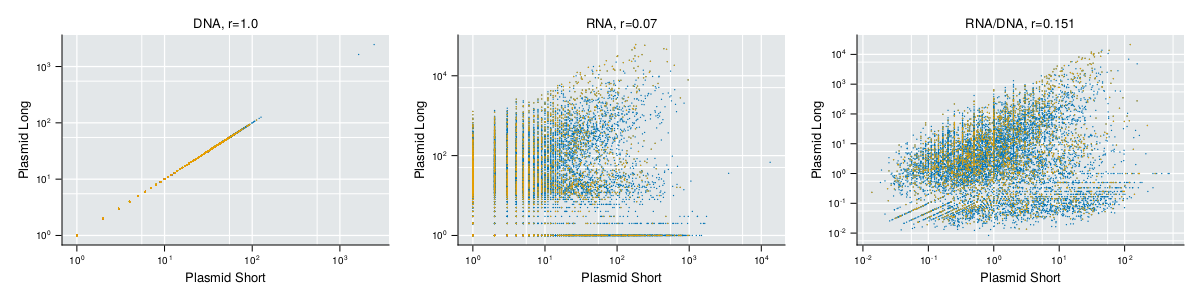

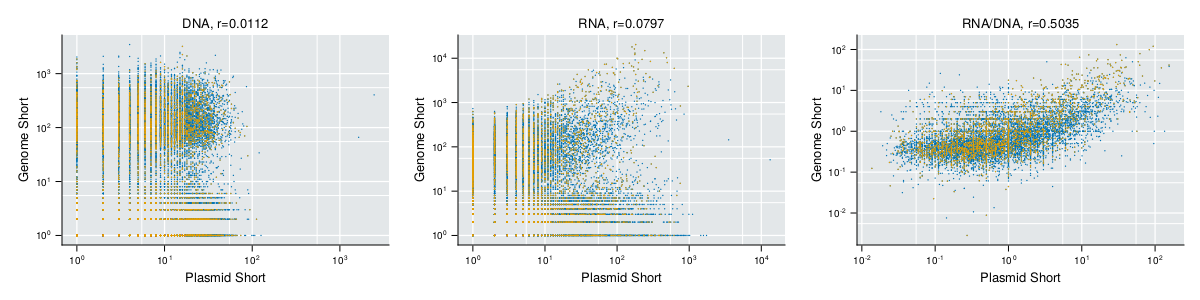

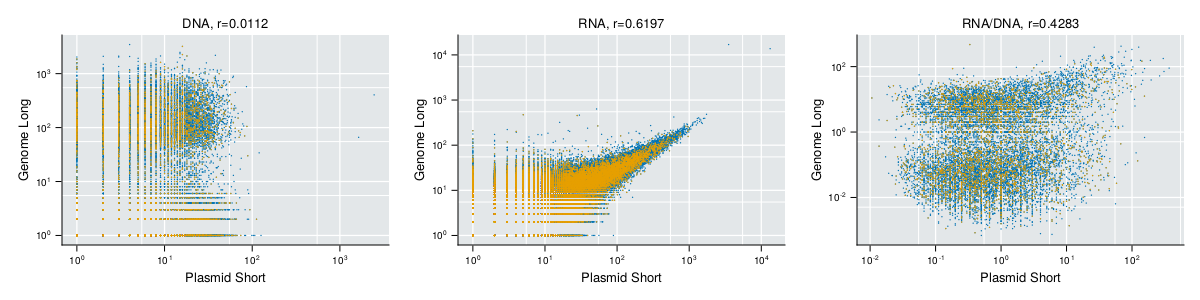

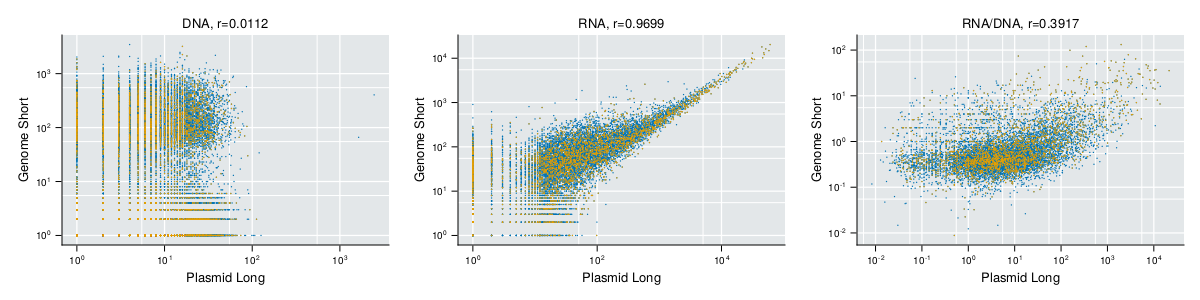

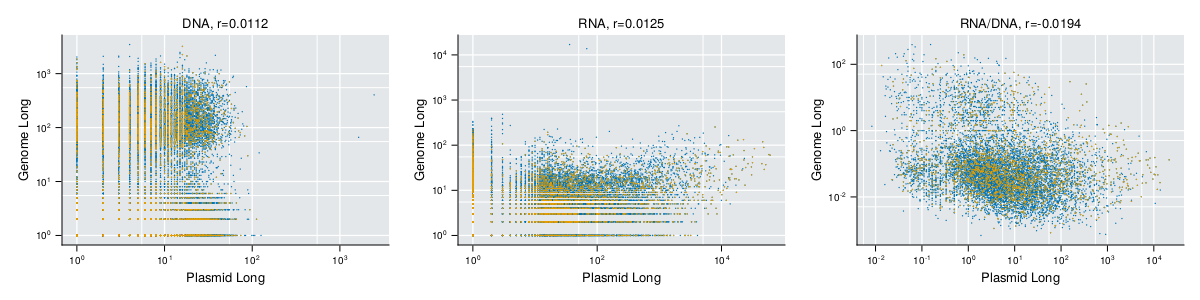

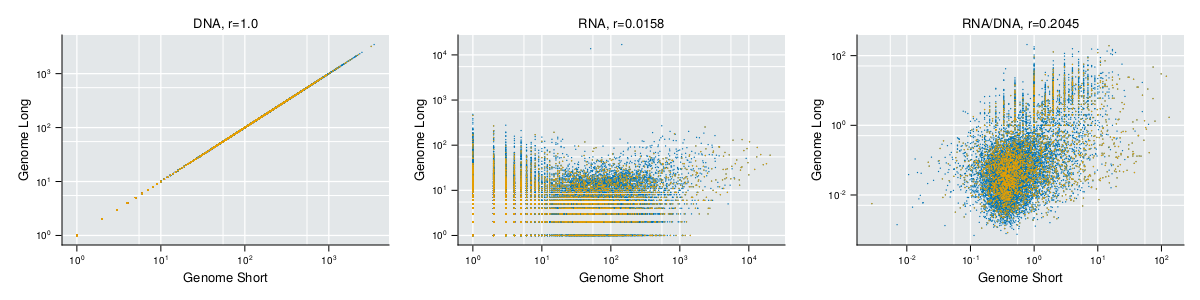

In [11]:
for i in 1:6
    display(fig_list[i])
end

## Reads per promoter variant

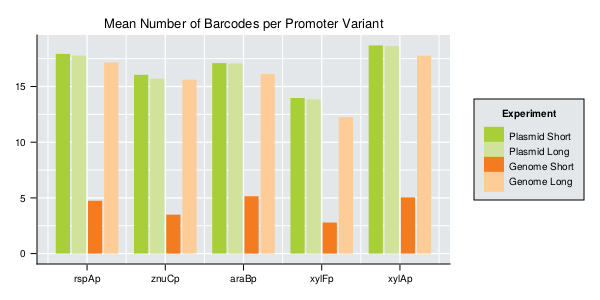

In [12]:
D = enumerate(["rspAp", "znuCp", "araBp", "xylFp", "xylAp"]) |> collect |> Dict 
D = Dict(D[k] => k for k in keys(D))
colors = [colors_dict["green1"], colors_dict["green2"], colors_dict["orange1"], colors_dict["orange2"]]

plot_df = DataFrame()

for (i, (df, lab))  in enumerate(zip([p88_df, p260_df, g88_df, g260_df], ["Plasmid Short", "Plasmid Long", "Genome Short", "Genome Long"]))
    _df  = df[map(x -> x ∈ ["rspAp", "znuCp", "araBp", "xylFp", "xylAp"], df.name), :]
    cdf = combine(groupby(_df, [:promoter, :name]), nrow)
    cdf = combine(groupby(cdf, :name), :nrow => mean)
    insertcols!(cdf, 1, :source => lab)
    insertcols!(cdf, 1, :source_ind => i)
    append!(plot_df, cdf)
end

insertcols!(plot_df, 1, :promoter_ind => [D[x] for x in plot_df.name])

fig = Figure(resolution=(600, 300))
ax = Axis(fig[1, 1], xticks=(1:5, ["rspAp", "znuCp", "araBp", "xylFp", "xylAp"]), title="Mean Number of Barcodes per Promoter Variant")
barplot!(
    ax, 
    plot_df.promoter_ind, 
    plot_df.nrow_mean, 
    dodge=plot_df.source_ind,  
    color = colors[plot_df.source_ind]
    )


labels = ["Plasmid Short", "Plasmid Long", "Genome Short", "Genome Long"]
elements = [PolyElement(polycolor = colors[i]) for i in 1:length(labels)]
title = "Experiment"

Legend(fig[1,2], elements, labels, title)

fig

## Importing Reg-Seq Data

To compare to the RegSeq dataset, we need to map the names of genes in our experiment to the ones from RegSeq. In RegSeq, the name was for the operon, while we only took the leading gene. Then, import the wild type sequences so can look if sequences are shifted.

In [13]:
prom_dict = Dict(
        "rspA" => "rspA",
        "znuC" => "znuCB",
        "xylA" => "xylA",
        "xylF" => "xylF",
        "araB" => "araAB"
)
# Import wild type sequences from reg seq
df_regseq_wt = CSV.read("../../../data/wtsequences_regseq.csv", DataFrame);

I created a table that contains all known binding sites on ecocyc for the gold standard genes. Import the table and define a dictionary that maps the TF type to a color.

In [14]:
site_color_dict = Dict(
        "rep" => (:red, 0.15),
        "act" => (:green, 0.15)
)
df_sites = CSV.read("known_sites.txt", DataFrame);

We need a function that can import the raw data from Reg-Seq for a certain promoter variant.

In [15]:
function regseq_data_import(promoter)
    # Import group numbers
    df = CSV.read("../../../data/genetogroupnum", DataFrame)

    # Get group number
    number = df[df.genename .== promoter, "pnum"][1]
    
    # Get mapping dataset
    mapping = CSV.read("../../../data/regseq_elife/mapping_sequences/$(number)_mapping_identified.csv", DataFrame)
    mapping = mapping[(mapping.name .== promoter) .& (mapping.nmut .< 30), :]

    # Get mapping dataset
    dna_counts = CSV.read("../../../data/regseq_elife/rna_dna_counts/LB_DNA_$(number)_expression_counted.csv", DataFrame, header=["ct_0", "barcode"])
    rna_counts = CSV.read("../../../data/regseq_elife/rna_dna_counts/LB_RNA_$(number)_expression_counted.csv", DataFrame, header=["ct_1", "barcode"])
    df_counts = outerjoin(dna_counts, rna_counts, on="barcode")

    # Idenitfy barcodes and replace missing values
    df_mapped = innerjoin(df_counts, mapping, on="barcode")
    replace!(df_mapped.ct_0, missing => 0)
    replace!(df_mapped.ct_1, missing => 0)
    insertcols!(df_mapped, 1, :ct => df_mapped.ct_0 .+ df_mapped.ct_1)

    return df_mapped

end

regseq_data_import (generic function with 1 method)

In [16]:
function plot_footprints_regseq(promoter; link_axis=true, d=0, norm=false, alpha=0.7)
    # Create figure
    fig = Figure(resolution=(1200, 200))
    
    # Create grid elements for nice plotting
    ga = fig[1, 1] = GridLayout()
    ga_list = []
    gb = fig[1, 2] = GridLayout()
    gb_list = []

    # Get Reg-Seq data for promoter
    df_reg = regseq_data_import(prom_dict[promoter[1:4]])
    exp_shift2 = wgregseq.footprints.expression_shift(df_reg)


    # Plot Canvas
    ax_a = Axis(ga[1, 1], xticks=-110:10:40)
    push!(ga_list, ax_a)
    ax_b = Axis(gb[1, 1], xticks=-110:10:40)
    push!(gb_list, ax_b)

    if d != 0
        exp_shift2 = [mean(exp_shift2[j-d:j+d]) for j in 1+d:160-d]
    end

    if norm
        exp_shift2 = exp_shift2 ./ maximum(exp_shift2)
    end
        
    ## relative entropy
    x2 = abs.(DelimitedFiles.readdlm("$(prom_dict[promoter[1:4]])LBdatasetinfofootprint.txt", skipstart=1)[:, 2])
    if d != 0
        x2 = [mean(x2[j-d:j+d]) for j in 1+d:160-d]
    end

    if norm 
        x2 = x2 ./ maximum(x2)
    end

    x_mult2 = exp_shift2 .* x2 #.^ 2

    
    barplot!(ax_a, collect(-115+d:44-d), exp_shift2, color=(colors_dict["orange1"], alpha))
    barplot!(ax_b, collect(-115+d:44-d), x2, color=(colors_dict["orange1"], alpha))

    if link_axis && ~norm
        linkyaxes!(ga_list...)
        linkyaxes!(gb_list...)
    end

    Label(ga[1, 1, Top()], "Expression Shift", valign = :bottom,
    font = :bold,
    padding = (0, 0, 5, 0))

    Label(gb[1, 1, Top()], "MCMC Relative Entropy", valign = :bottom,
    font = :bold,
    padding = (0, 0, 5, 0))
    return fig
end

fig = plot_footprints_regseq("rspAp", link_axis=false, d=1, norm=true)
save("rspAp_regseq.pdf", fig)

fig = plot_footprints_regseq("znuCp", link_axis=false, d=1, norm=true)
save("znuCp_regseq.pdf", fig)

fig = plot_footprints_regseq("xylFp", link_axis=false, d=1, norm=true)
save("xylFp_regseq.pdf", fig)

fig = plot_footprints_regseq("xylAp", link_axis=false, d=1, norm=true)
save("xylAp_regseq.pdf", fig)

fig = plot_footprints_regseq("araBp", link_axis=false, d=1, norm=true)
save("araBp_regseq.pdf", fig)

CairoMakie.Screen{PDF}


## Plot footprints

We plot footprints for the data obtained from Reg-Seq and from the control experiment run. To compare the two runs, we are going to plot obtained footprints on top of each other for various ways of computing footprints. Here we are going to start with:
- Expression shifts
- Mutual information (Mutation, DNA or RNA count)
- Relative Entropy from MCMC

[0.00015608521694669957, 9.718688914163703e-5, 0.00026818489227321655, 0.0002908884780304698, 5.0240172000811035e-5, 0.00010839636408253357, 0.00014344505825799082, 0.0006892174242207963, 0.00014680556290822162, 0.0004321204855038622, 8.653248095829517e-5, 0.0006102207777333862, 0.00021282224926778555, 0.00017282433534954178, 0.0004524345289160375, 7.163446801691309e-5, 0.00026607427783468217, 0.000708078812938228, 0.0003231213315256498, 0.0011262315050329028, 0.00045546810824661187, 0.0005331894944465773, 0.000149736063747824, 1.8669554671166765e-5, 0.00010486785167029399, 0.00038703396821045295, 0.0009025638387651952, 0.000319315569821948, 0.0007373833544381762, 1.4517328075044369e-5, 0.00034619127366807, 0.0004921084805074348, 0.00014141187806065384, 0.00012166445201309758, 2.13249092356569e-5, 0.0002218628529236065, 0.00038117038689323285, 0.00015565474099140351, 0.0001760642512363443, 0.000497301829383694, 0.0003209549874719931, 3.310057853252602e-5, 0.0007635108409908727, 0.00012

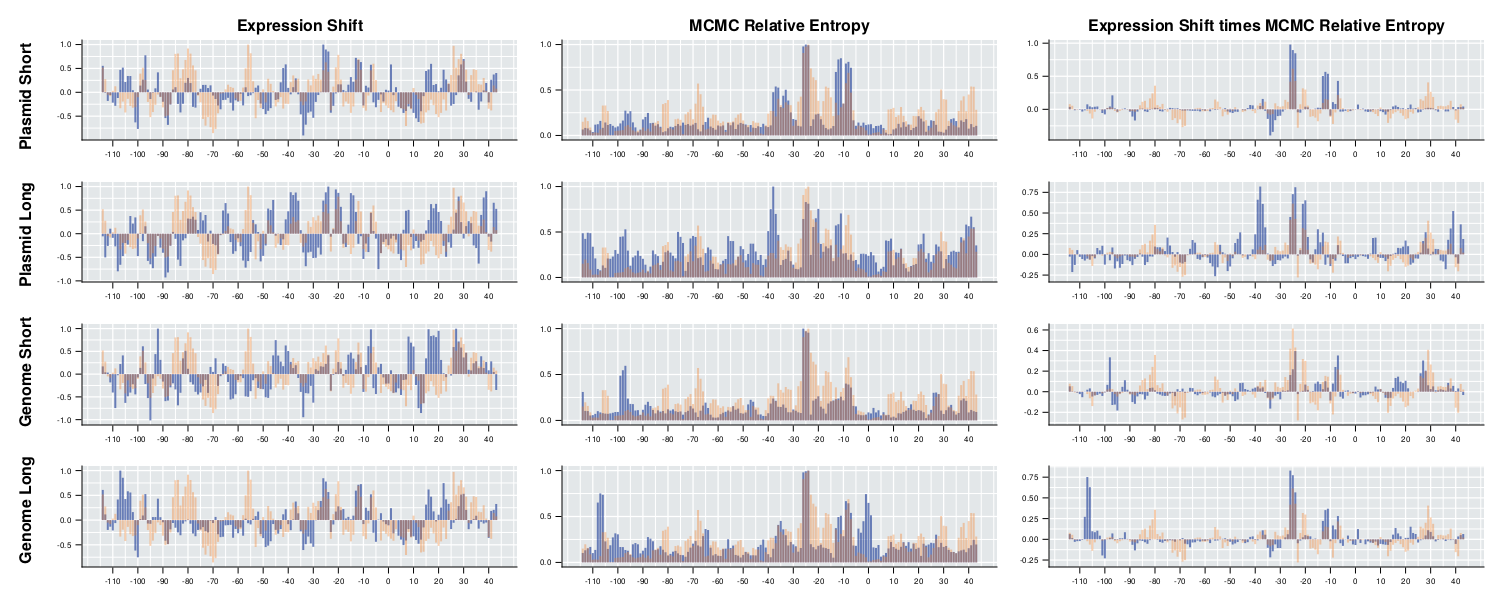

In [37]:
function plot_footprints(promoter, date; link_axis=true, d=0, norm=false, alpha=0.7, plot_regseq=true)
    # Create figure
    fig = Figure(resolution=(1500, 600))
    
    # Create grid elements for nice plotting
    g0 = fig[1, 1] = GridLayout()
    ga = fig[1, 2] = GridLayout()
    ga_list = []
    gb = fig[1, 3] = GridLayout()
    gb_list = []
    gc = fig[1, 4] = GridLayout()
    gc_list = []

    # Get Reg-Seq data for promoter
    df_reg = regseq_data_import(prom_dict[promoter[1:4]])
    
    # Extract data from dataframe
    for (i, ind) in enumerate(["p88", "p260", "g88", "g260"])
        # load dataframe
        df = CSV.read(ind*"_barcodes.csv", DataFrame)

        # Only look at promoter
        df = df[df.name .== promoter, :]
        #df = df[df.ct .< 500, :]

        # find wild type sequence and offset for regseq sequence
        freq_mat = wgregseq.footprints.frequency_matrix(df[df.name .== promoter, :])
        wt_seq = argmax(sum(freq_mat, dims=1), dims=2) |> vec
        wt_seq = map(x -> x[2], wt_seq);
        regseq_wt = df_regseq_wt[df_regseq_wt.name .== prom_dict[promoter[1:4]], "geneseq"][1] |> wgregseq.footprints.make_int;
        offset = collect(-100:100)[findall(x -> x == 0, [sum(wt_seq[max(1, (-i+1)):min(160,160-i)] .!= regseq_wt[max(1, i+1):min(160,160+i)]) for i in -100:100])]

        ## expression shift
        exp_shift = wgregseq.footprints.expression_shift(df)
        exp_shift2 = wgregseq.footprints.expression_shift(df_reg)

        # -10 region scanner
        #=
        scanner = wgregseq.utils.onehot_encoder("TATAAT") .* -2 .+ 1 |> Matrix
        seq_OH = wgregseq.utils.onehot_encoder(df_wt[df_wt.promoter .== promoter, :promoter_seq][1]) .* exp_shift
        seq_OH2 = wgregseq.utils.onehot_encoder(df_wt[df_wt.promoter .== promoter, :promoter_seq][1]) .* exp_shift2

        y = [sum(seq_OH[i:i+5, :] .* scanner) for i in 1:154]
        y2 = [sum(seq_OH2[i:i+5, :] .* scanner) for i in 1:154]
        =#

        # Plot Canvas
        ax_a = Axis(ga[i, 1], xticks=-110:10:40, xticklabelsize=8, yticklabelsize=8)
        push!(ga_list, ax_a)
        ax_b = Axis(gb[i, 1], xticks=-110:10:40, xticklabelsize=8, yticklabelsize=8)
        push!(gb_list, ax_b)
        ax_c = Axis(gc[i, 1], xticks=-110:10:40, xticklabelsize=8, yticklabelsize=8)
        push!(gc_list, ax_c)

        if d != 0
            exp_shift = [mean(exp_shift[j-d:j+d]) for j in 1+d:160-d]
            exp_shift2 = [mean(exp_shift2[j-d:j+d]) for j in 1+d:160-d]
        end

        if norm
            exp_shift = exp_shift ./ maximum(exp_shift)
            exp_shift2 = exp_shift2 ./ maximum(exp_shift2)
        end
        
        ## relative entropy

        mcmc = CSV.read("footprints/" * date * "_" * ind * "_" * promoter * "_mcmc_mpathic_1_.csv", DataFrame)[!, ["val_A", "val_C", "val_G", "val_T"]] |> Matrix
        prob_mat = exp.(mcmc) ./ sum(exp.(mcmc), dims=2)
        x = sum(prob_mat .* log2.(prob_mat ./ 0.25), dims=2) |> vec
        println(x)

        x2 = abs.(DelimitedFiles.readdlm("$(prom_dict[promoter[1:4]])LBdatasetinfofootprint.txt", skipstart=1)[:, 2])
        if d != 0
            x = [mean(x[j-d:j+d]) for j in 1+d:160-d]
            x2 = [mean(x2[j-d:j+d]) for j in 1+d:160-d]
        end

        if norm 
            x = x ./ maximum(x)
            x2 = x2 ./ maximum(x2)
        end

        x_mult = exp_shift .* x #.^ 2
        x_mult2 = exp_shift2 .* x2 #.^ 2


        barplot!(ax_a, -115+d:44-d, exp_shift, color=(colors_dict["blue1"], alpha))
        barplot!(ax_b, -115+d:44-d, x, color=(colors_dict["blue1"], alpha))
        barplot!(ax_c, -115+d:44-d, x_mult, color=(colors_dict["blue1"], alpha))
        #lines!(ax_c, -115:38, y, color=(colors[1], alpha))


        if plot_regseq
            barplot!(ax_a, collect(-115+d:44-d) .- offset, exp_shift2, color=(colors_dict["orange1"], alpha/2))
            barplot!(ax_b, collect(-115+d:44-d) .- offset, x2, color=(colors_dict["orange1"], alpha/2))
            #lines!(ax_c, -115:38, x2, color=(colors_dict["orange1"], alpha))
            barplot!(ax_c, collect(-115+d:44-d) .- offset, x_mult2, color=(colors_dict["orange1"], alpha/2))
        end



    end 

    if link_axis && ~norm
        linkyaxes!(ga_list...)
        linkyaxes!(gb_list...)
        linkyaxes!(gc_list...)
    end

    Label(ga[1, 1, Top()], "Expression Shift", valign = :bottom,
    font = :bold,
    padding = (0, 0, 5, 0))


    Label(gb[1, 1, Top()], "MCMC Relative Entropy", valign = :bottom,
    font = :bold,
    padding = (0, 0, 5, 0))
    
    Label(gc[1, 1, Top()], "Expression Shift times MCMC Relative Entropy", valign = :bottom,
    font = :bold,
    padding = (0, 0, 5, 0))
    #=
    Label(gc[1, 1, Top()], "-10 Scanner", valign = :bottom,
    font = :bold,
    padding = (0, 0, 5, 0))
    =#

    Label(g0[1, 1], "Plasmid Short", rotation = pi/2, tellheight = false, font = :bold)
    Label(g0[2, 1], "Plasmid Long", rotation = pi/2, tellheight = false, font = :bold)
    Label(g0[3, 1], "Genome Short", rotation = pi/2, tellheight = false, font = :bold)
    Label(g0[4, 1], "Genome Long", rotation = pi/2, tellheight = false, font = :bold)

    colsize!(fig.layout, 1, Auto(0.))

    return fig
end

fig = plot_footprints("xylFp", "2023-04-13", link_axis=false, d=1, norm=true, plot_regseq=true)
save("xylFp_w_regseq.pdf", fig)
display(fig)

In [18]:
for prom in ["znuCp", "araBp", "xylFp", "xylAp"]
    fig = plot_footprints(prom, "2023-04-13", link_axis=false, d=1, norm=true, plot_regseq=true)
    save("$(prom)_w_regseq.pdf", fig)

    fig = plot_footprints(prom, "2023-04-13", link_axis=false, d=1, norm=true, plot_regseq=false)
    save("$(prom).pdf", fig)
end

## Expression Shifts per base

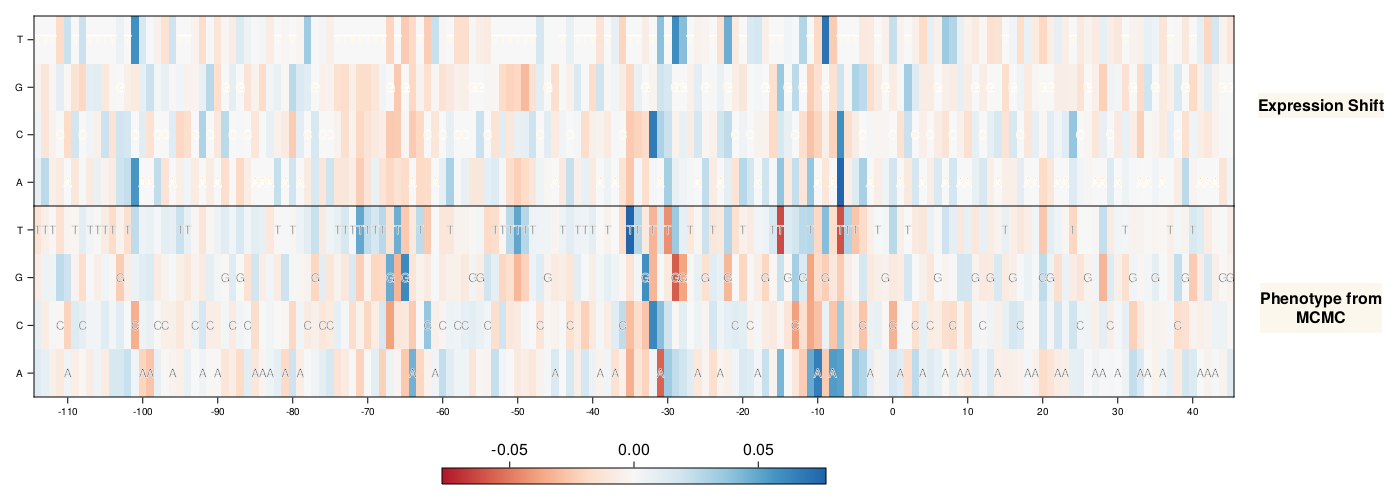

In [19]:

prom = "rspAp"
date = "2023-04-13"
_df_rna = CSV.read("../../../data/extracted_barcodes/20230327_barcode/RP88_collapsed.txt", DataFrame, ignorerepeated=true, delim=" ", header=["ct_1", "barcode"])
_df_dna = CSV.read("../../../data/extracted_barcodes/20230327_barcode/DP_collapsed.txt", DataFrame, ignorerepeated=true, delim=" ", header=["ct_0", "barcode"])
_df = outerjoin(_df_dna, _df_rna, on=:barcode)
replace!(_df.ct_0, missing => 0)
replace!(_df.ct_1, missing => 0)
_df = innerjoin(_df, df_map, on=:barcode)

# Compute relative (with pseudo counts)
insertcols!(_df, 1, :relative_counts => (_df.ct_1 .+ 1) ./ (_df.ct_0 .+ 1))
insertcols!(_df, 1, :ct => _df.ct_1 .+ _df.ct_0)
_df = _df[_df.name .== prom, :]

# Turn sequences into integer
insertcols!(_df, 3, :int_promoter => wgregseq.footprints.make_int.(_df[:, :promoter]))
    
freq_mat = wgregseq.footprints.frequency_matrix(_df)
# find wild type sequence 
wt_seq = argmax(sum(freq_mat, dims=1), dims=2) |> vec
wt_seq = map(x -> x[2], wt_seq)
wt_seq_dna = [wgregseq.footprints.DNA_dict_rev[x] for x in wt_seq]

function is_mut(x)
    return x .!= wt_seq
end

insertcols!(_df, 4, :is_mutated => is_mut.(_df.int_promoter))
mean_rel_counts = mean(_df.relative_counts)

ex_shift_arr = zeros(4, 160)
for (x, seq, mut) in zip(_df.relative_counts, _df.int_promoter, _df.is_mutated)
    for i in 1:160
        ex_shift_arr[seq[i], i] +=  (x - mean_rel_counts) / mean_rel_counts * mut[i]
    end
end
ex_shift_arr = ex_shift_arr ./ nrow(_df)

mcmc = CSV.read("footprints/" * date * "_" * "p88" * "_" * prom * "_mcmc_mpathic_1_.csv", DataFrame)[!, ["val_A", "val_C", "val_G", "val_T"]] |> Matrix
mcmc = mcmc ./ maximum(abs.(mcmc)) .* maximum(abs.(ex_shift_arr))

fig = Figure(resolution=(1400, 500))

ga = fig[1:2, 1:6] = GridLayout()
gb = fig[3, 3:4] = GridLayout()

ax = Axis(
    ga[1, 1], 
    yticks=(1:4, ["A", "C", "G", "T"]), 
    xticks=(5:10:155, string.(collect(-110:10:40))),
    topspinevisible = true,
    rightspinevisible = true
    )

ax2 = Axis(
    ga[2, 1], 
    yticks=(1:4, ["A", "C", "G", "T"]), 
    xticks=(5:10:155, string.(collect(-110:10:40))),
    rightspinevisible = true
    )

hm = heatmap!(
    ax, 
    ex_shift_arr', 
    colorrange=(-maximum(abs.(ex_shift_arr)), maximum(abs.(ex_shift_arr))), 
    colormap=:RdBu_9
    )

hm3 = heatmap!(
    ax2, 
    mcmc, 
    colorrange=(-maximum(abs.(ex_shift_arr)), 
    maximum(abs.(ex_shift_arr))), 
    colormap=:RdBu_9
    )

hidexdecorations!(ax, grid = false)
rowgap!(ga, 0)

Colorbar(gb[1, 1], hm, vertical = false) 

g0 = fig[1, 7] = GridLayout()
Box(g0[1, 1], color = ("#F3DAA9", 0.2), strokewidth = 0, height = 25, tellheight = false)
Label(g0[1, 1], "Expression Shift", tellheight = false, font = :bold)


g0 = fig[2, 7] = GridLayout()
Box(g0[1, 1], color = ("#F3DAA9", 0.2), strokewidth = 0, height = 50, tellheight = false)
Label(g0[1, 1], "Phenotype from\nMCMC", tellheight = false, font = :bold)


scatter!(
    ax, 
    1:160, 
    wt_seq, 
    color="orange", 
    marker=wt_seq_dna,
    strokewidth=1,
    strokecolor="white"
)
scatter!(
    ax2, 
    1:160, 
    wt_seq, 
    color="black", 
    marker=wt_seq_dna,
    strokewidth=0.7,
    strokecolor="white"
)
#=
for i in 1:160
    lines!(
        ax, 
        [i-0.5, i-0.5, i+0.5, i+0.5, i-0.5], 
        [wt_seq[i] - 0.5, wt_seq[i]+0.5, wt_seq[i]+0.5, wt_seq[i]-0.5, wt_seq[i]-0.5], 
        color="black", 
        linestyle=:dash,
        linewidth=0.75
        )
    lines!(
        ax2, 
        [i-0.5, i-0.5, i+0.5, i+0.5, i-0.5], 
        [wt_seq[i] - 0.5, wt_seq[i]+0.5, wt_seq[i]+0.5, wt_seq[i]-0.5, wt_seq[i]-0.5], 
        color="black",
        linestyle=:dash,
        linewidth=0.75
        )
end

fig
=#
fig

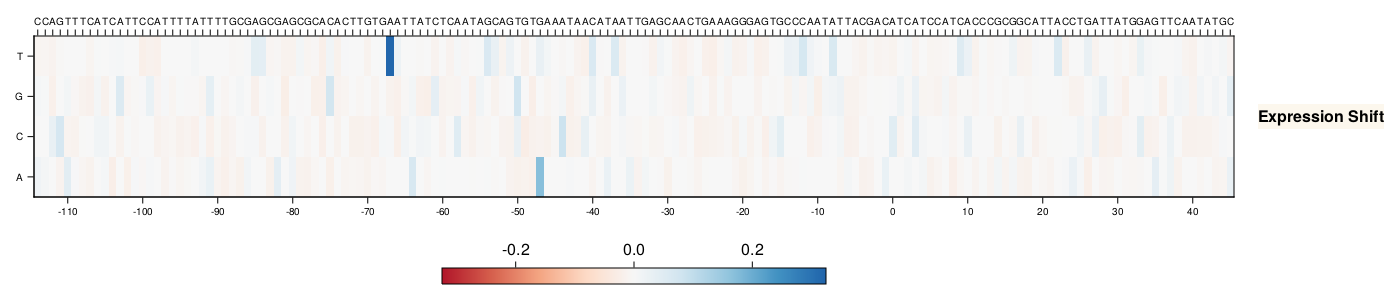

In [20]:

prom = "xylAp"
date = "2023-04-13"
_df_rna = CSV.read("../../../data/extracted_barcodes/20230327_barcode/RP88_collapsed.txt", DataFrame, ignorerepeated=true, delim=" ", header=["ct_1", "barcode"])
_df_dna = CSV.read("../../../data/extracted_barcodes/20230327_barcode/DP_collapsed.txt", DataFrame, ignorerepeated=true, delim=" ", header=["ct_0", "barcode"])
_df = outerjoin(_df_dna, _df_rna, on=:barcode)
replace!(_df.ct_0, missing => 0)
replace!(_df.ct_1, missing => 0)
_df = innerjoin(_df, df_map, on=:barcode)

# Compute relative (with pseudo counts)
insertcols!(_df, 1, :relative_counts => (_df.ct_1 .+ 1) ./ (_df.ct_0 .+ 1))
insertcols!(_df, 1, :ct => _df.ct_1 .+ _df.ct_0)
_df = _df[_df.name .== prom, :]

# Turn sequences into integer
insertcols!(_df, 3, :int_promoter => wgregseq.footprints.make_int.(_df[:, :promoter]))
    
freq_mat = wgregseq.footprints.frequency_matrix(_df)
# find wild type sequence 
wt_seq = argmax(sum(freq_mat, dims=1), dims=2) |> vec
wt_seq = map(x -> x[2], wt_seq)
wt_seq_dna = [wgregseq.footprints.DNA_dict_rev[x] for x in wt_seq]

function is_mut(x)
    return x .!= wt_seq
end

insertcols!(_df, 4, :is_mutated => is_mut.(_df.int_promoter))
mean_rel_counts = mean(_df.relative_counts)

ex_shift_arr = zeros(4, 160)
for (x, seq, mut) in zip(_df.relative_counts, _df.int_promoter, _df.is_mutated)
    for i in 1:160
        ex_shift_arr[seq[i], i] +=  (x - mean_rel_counts) / mean_rel_counts * mut[i]
    end
end
ex_shift_arr = ex_shift_arr ./ nrow(_df)


fig = Figure(resolution=(1400, 300))

ga = fig[1, 1:6] = GridLayout()
gb = fig[2, 3:4] = GridLayout()

ax = Axis(
    ga[1, 1], 
    yticks=(1:4, ["A", "C", "G", "T"]), 
    xticks=(5:10:155, string.(collect(-110:10:40))),
    topspinevisible = true,
    rightspinevisible = true
)
ax2 = Axis(
    ga[1, 1], 
    xticks=(1:160, string.(wt_seq_dna)),
    xaxisposition = :top
)

hm = heatmap!(
    ax, 
    ex_shift_arr', 
    colorrange=(-maximum(abs.(ex_shift_arr)), maximum(abs.(ex_shift_arr))), 
    colormap=:RdBu_9
)
xlims!(0.5, 160.5)

#hidexdecorations!(ax, grid = false)

hideydecorations!(ax2)
linkxaxes!(ax, ax2)

Colorbar(gb[1, 1], hm, vertical = false) 

g0 = fig[1, 7] = GridLayout()
Box(g0[1, 1], color = ("#F3DAA9", 0.2), strokewidth = 0, height = 25, tellheight = false)
Label(g0[1, 1], "Expression Shift", tellheight = false, font = :bold)

save("$(prom)_heatmap.pdf", fig)
fig

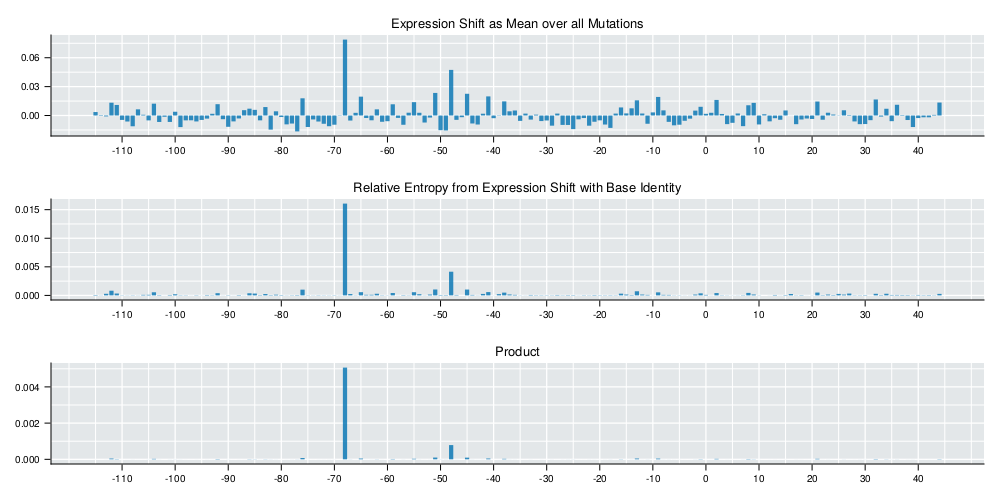

In [21]:
prob_mat = exp.(ex_shift_arr) ./ sum(exp.(ex_shift_arr), dims=1)
x = sum(prob_mat .* log2.(prob_mat ./ 0.25), dims=1) |> vec

fig = Figure(resolution=(1000, 500))
ax1 = Axis(fig[1, 1], xticks=(-110:10:40), title="Expression Shift as Mean over all Mutations")
barplot!(ax1, -115:44, vec(mean(ex_shift_arr, dims=1)))

ax2 = Axis(fig[2, 1], xticks=(-110:10:40), title="Relative Entropy from Expression Shift with Base Identity")
barplot!(ax2, -115:44, x)

ax3 = Axis(fig[3, 1], xticks=(-110:10:40), title="Product")
barplot!(ax3, -115:44, x .* vec(sum(ex_shift_arr, dims=1)))

fig

In [22]:
sum([wgregseq.footprints.clog(y, 0.25, 1) for y in [0.1, 0.1, 0.1, 0.7]])

0.6432203505529606

In [23]:
fig = plot_footprints("araBp", link_axis=false, d=1, norm=true)
save("araB_footprints_normalized_3.pdf", fig)

fig = plot_footprints("araBp", link_axis=false, d=1, norm=false)
save("araB_footprints_3.pdf", fig)

LoadError: MethodError: no method matching plot_footprints(::String; link_axis::Bool, d::Int64, norm::Bool)

[0mClosest candidates are:
[0m  plot_footprints(::Any, [91m::Any[39m; link_axis, d, norm, alpha, plot_regseq)
[0m[90m   @[39m [35mMain[39m [90m[4mIn[17]:1[24m[39m


In [ ]:
fig = plot_footprints("znuCp", link_axis=false, d=1, norm=true)
save("znuC_footprints_normalized_3.pdf", fig)

fig = plot_footprints("znuCp", link_axis=false, d=1, norm=false)
save("znuC_footprints_3.pdf", fig)

CairoMakie.Screen{PDF}


In [ ]:
fig = plot_footprints("xylFp", link_axis=false, d=1, norm=true)
save("xylF_footprints_normalized_3.pdf", fig)

fig = plot_footprints("xylFp", link_axis=false, d=1, norm=false)
save("xylF_footprints_3.pdf", fig)

CairoMakie.Screen{PDF}


In [ ]:
fig = plot_footprints("xylAp", link_axis=false, d=1, norm=true)
save("xylA_footprints_normalized_3.pdf", fig)

fig = plot_footprints("xylAp", link_axis=false, d=1, norm=false)
save("xylA_footprints_3.pdf", fig)

CairoMakie.Screen{PDF}


In [ ]:
color_sign_dict = Dict(1 => colors_dict["red1"], -1 => colors_dict["blue1"])

Dict{Int64, String} with 2 entries:
  -1 => "#324fa2"
  1  => "#D14241"

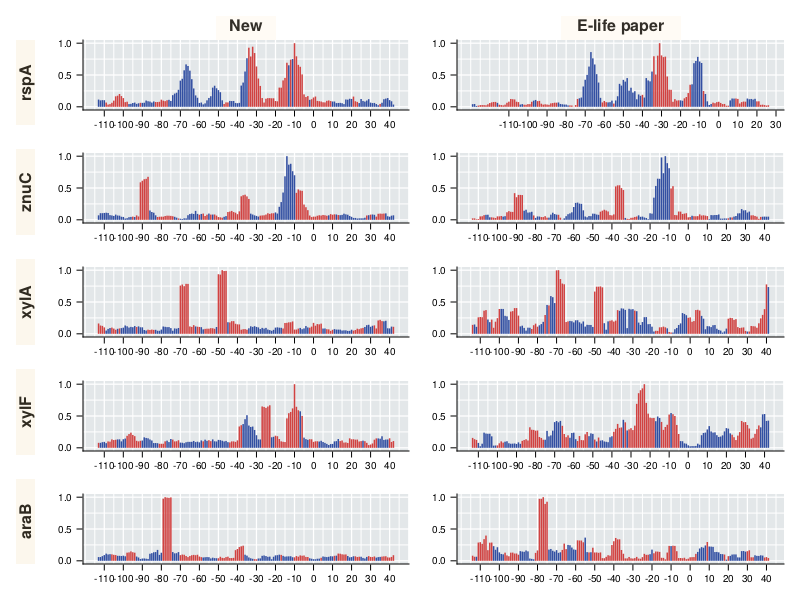

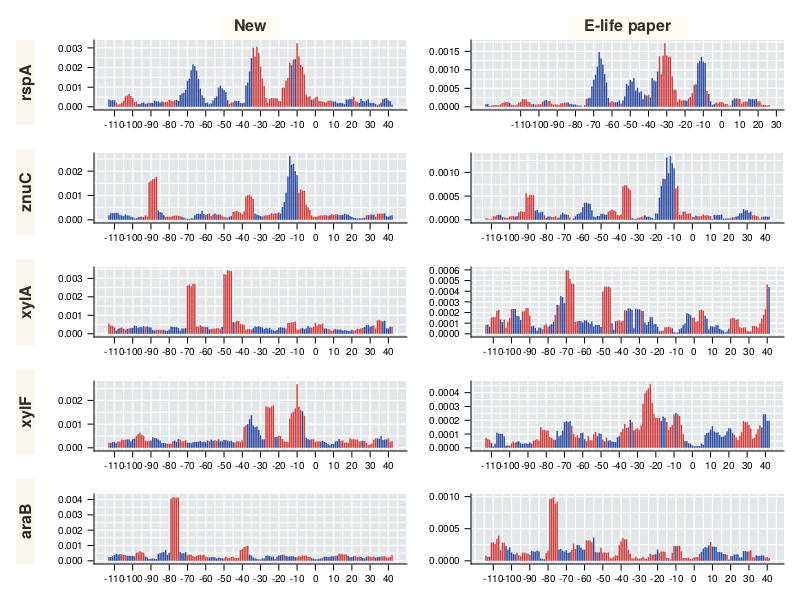

In [ ]:
function plot_footprints_figure(;link_axis=true, d=0, norm=false, alpha=0.7)
    # Create figure
    fig = Figure(resolution=(800, 600))
    
    g0 = fig[1, 1] = GridLayout()
    ga = fig[1, 2] = GridLayout()
    ga_list = []
    gb = fig[1, 3] = GridLayout()
    gb_list = []
    
    
    df_all = CSV.read("p88_barcodes.csv", DataFrame)
    # Extract data from dataframe
    for (i, prom) in enumerate(["rspAp", "znuCp", "xylAp", "xylFp", "araBp"])
        # Only look at promter
        df_reg = regseq_data_import(prom_dict[prom[1:4]])
        df = df_all[df_all.name .== prom, :]
        df = df[df.ct .< 1000, :]

        # find wild type sequence and offset for regseq sequence
        freq_mat = wgregseq.footprints.frequency_matrix(df[df.name .== prom, :])
        wt_seq = argmax(sum(freq_mat, dims=1), dims=2) |> vec
        wt_seq = map(x -> x[2], wt_seq);
        regseq_wt = df_regseq_wt[df_regseq_wt.name .== prom_dict[prom[1:4]], "geneseq"][1] |> wgregseq.footprints.make_int;
        offset = collect(-100:100)[findall(x -> x == 0, [sum(wt_seq[max(1, (-i+1)):min(160,160-i)] .!= regseq_wt[max(1, i+1):min(160,160+i)]) for i in -100:100])]

        # expression shift
        exp_shift = wgregseq.footprints.expression_shift(df)
        exp_shift2 = wgregseq.footprints.expression_shift(df_reg)
        if d != 0
            exp_shift = [mean(exp_shift[j-d:j+d]) for j in 1+d:160-d]
            exp_shift2 = [mean(exp_shift2[j-d:j+d]) for j in 1+d:160-d]
        end
        exp_sign = [color_sign_dict[x] for x in sign.(exp_shift)]
        exp_sign2 = [color_sign_dict[x] for x in sign.(exp_shift2)]
        # relative entropy
        ax = Axis(ga[i, 1], xticks=-110:10:40)
        push!(gb_list, ax)

        mcmc = CSV.read("footprints/p88_" * prom * "_mcmc_mpathic_2.csv", DataFrame)[!, ["val_A", "val_C", "val_G", "val_T"]] |> Matrix
        prob_mat = exp.(mcmc) ./ sum(exp.(mcmc), dims=2)
        x = sum(prob_mat .* log2.(prob_mat ./ 0.25), dims=2) |> vec
        if d > 0
            if norm
                x = x ./ maximum(x)
            end
            barplot!(ax, -115:44, x, color=exp_sign)
        else
            x_norm = [mean(x[j-d:j+d]) for j in 1+d:160-d]
            if norm
                x_norm = x_norm ./ maximum(x_norm)
            end
            barplot!(ax, -115+d:44-d, x_norm, color=exp_sign)
        end

        ax2 = Axis(gb[i, 1], xticks=-110:10:40)
        x2 = abs.(DelimitedFiles.readdlm("$(prom_dict[prom[1:4]])LBdatasetinfofootprint.txt", skipstart=1)[:, 2])

        if d > 0
            x2 = [mean(x2[j-d:j+d]) for j in 1+d:160-d]
        end
        if norm
            x2 = x2 ./ maximum(x2)
        end
        barplot!(ax2, collect(-115+d:44-d) .- offset, x2, color=exp_sign2)
        fill_between!(ax2, [sites[i, :start], sites[i, :end]], [0, 0], [maximum(x2), maximum(x2)], color=site_color_dict[sites[i, :type]])

        Label(g0[i, 1], prom[1:4], rotation = pi/2, tellheight = false, font = :bold)
        Box(g0[i, 1], color = ("#F3DAA9", 0.2), strokewidth = 0)

        sites = df_sites[df_sites.promoter .== prom, :]
        for i in 1:nrow(sites)
            if norm
                fill_between!(ax, [sites[i, :start], sites[i, :end]], [0, 0], [1, 1], color=site_color_dict[sites[i, :type]])
                
            else
                fill_between!(ax, [sites[i, :start], sites[i, :end]], [0, 0], [1, 1], color=site_color_dict[sites[i, :type]])
                
        end

    end 

    if link_axis && ~norm
        linkyaxes!(ga_list...)
        linkyaxes!(gb_list...)
    end

    Label(ga[1, 1, Top()], "New", valign = :bottom,
    font = :bold,
    padding = (0, 0, 5, 0))
    Box(ga[1, 1, Top()], color = ("#FFEDCD", 0.2), strokewidth = 0, width=60)
    

    Label(gb[1, 1, Top()], "E-life paper", valign = :bottom,
    font = :bold,
    padding = (0, 0, 5, 0))
    Box(gb[1, 1, Top()], color = ("#FFEDCD", 0.2), strokewidth = 0, width=120)

    colsize!(fig.layout, 1, Auto(0.))

    return fig
end

fig = plot_footprints_figure(link_axis=false, d=2, norm=true)
display(fig)
save(string(Dates.today())*"_footprints_normalized.pdf", fig)

fig = plot_footprints_figure(link_axis=false, d=2, norm=false)
display(fig)
save(string(Dates.today())*"_footprints.pdf", fig)

In [ ]:
_df = p88_df[p88_df.name .== "rspAp", :]

# Turn sequences into integer
insertcols!(_df, 3, :int_promoter => wgregseq.footprints.make_int.(_df[:, :promoter]))
    
freq_mat = wgregseq.footprints.frequency_matrix(_df)
# find wild type sequence 
wt_seq = argmax(sum(freq_mat, dims=1), dims=2) |> vec
wt_seq = map(x -> x[2], wt_seq)
wt_seq_dna = [wgregseq.footprints.DNA_dict_rev[x] for x in wt_seq]
wt_seq_dna[collect(-70-20:-45+20) .+ 115];

### lacO1 site

In [ ]:
# Import genome
re = open(FASTA.Reader, "../../../data/ecocyc/mg1655_genome.fasta")
wt_sequence = string(LongDNA{4}([sequence(record) for record in re][1]))
wt_sequence

"AGCTTTTCATTCTGACTGCAACGGGCAATATGTCTCTGTGTGGATTAAAAAAAGAGTGTCTGATAGCAGCTTCTGAACTGGTTACCTGCCGTGAGTAAATTAAAATTTTATTGACTTAGGTCACTAAATACTTTAACCAATATAGGCATAGCGCACAGACAGATAAAAATTACAGAGTACACAACATCCATGAAACGCATTAGCACCACCATTACCACCACCATCACCATTACCACAGGTAACGGTGCGGGCTGACGCGTACAGGAAAC" ⋯ 4641115 bytes ⋯ "GATGGTCTATTGCTATCAATTAGCAACATTAATACAACAACCGGCGAAAAGTGATGCAACGGCAGACCAACATCAACTGCAAGCTTTACGCGAACGAGCCATGACATTGCTGACGACTCTGGCAGTGGCAGATGACATAAAACTGGTCGACTGGTTACAACAACGCCTGGGGCTTTTAGAGCAACGAGACACGGCAATGTTGCACCGTTTGCTGCATGATATTGAAAAAAATATCACCAAATAAAAAACGCCTTAGTAAGTATTTTTC"

In [ ]:
x = wgregseq.design.find_seq(366343, "-", 10, 21+10, wt_sequence)[1]

41nt DNA Sequence:
GTTGTGTGGAATTGTGAGCGGATAACAATTTCACACAGGAA

In [ ]:
wgregseq.design.mass_spec_oligo(x, collect(20:41); IDT=true, name="lacO1")

lacO1_antisense_mutated,AGGTCTAAGCCCTACTCCCCTGGCTCACAATTCCACACAACAGCTAGCTGCAGAGCTAG,25nm,STD
lacO1_mutated,/5Biosg/ctagctCTGCAGctagctGTTGTGTGGAATTGTGAGCCAGGGGAGTAGGGCTTAGACCT,25nm,STD
lacO1_binding,/5Biosg/ctagctCTGCAGctagctGTTGTGTGGAATTGTGAGCGGATAACAATTTCACACAGGAA,25nm,STD
lacO1_antisense_binding,TTCCTGTGTGAAATTGTTATCCGCTCACAATTCCACACAACAGCTAGCTGCAGAGCTAG,25nm,STD



### CRP site in rspAp

First the sequence with mutation of full sequence

In [ ]:
x = wt_seq_dna[collect(-70-9:-48+9) .+ 115];
wt_seq_dna[collect(-70:-48) .+ 115]

23-element Vector{Char}:
 'T': ASCII/Unicode U+0054 (category Lu: Letter, uppercase)
 'T': ASCII/Unicode U+0054 (category Lu: Letter, uppercase)
 'T': ASCII/Unicode U+0054 (category Lu: Letter, uppercase)
 'G': ASCII/Unicode U+0047 (category Lu: Letter, uppercase)
 'T': ASCII/Unicode U+0054 (category Lu: Letter, uppercase)
 'G': ASCII/Unicode U+0047 (category Lu: Letter, uppercase)
 'A': ASCII/Unicode U+0041 (category Lu: Letter, uppercase)
 'T': ASCII/Unicode U+0054 (category Lu: Letter, uppercase)
 'C': ASCII/Unicode U+0043 (category Lu: Letter, uppercase)
 'A': ASCII/Unicode U+0041 (category Lu: Letter, uppercase)
 'C': ASCII/Unicode U+0043 (category Lu: Letter, uppercase)
 'T': ASCII/Unicode U+0054 (category Lu: Letter, uppercase)
 'C': ASCII/Unicode U+0043 (category Lu: Letter, uppercase)
 'C': ASCII/Unicode U+0043 (category Lu: Letter, uppercase)
 'G': ASCII/Unicode U+0047 (category Lu: Letter, uppercase)
 'G': ASCII/Unicode U+0047 (category Lu: Letter, uppercase)
 'C': ASCII/Uni

In [ ]:
wgregseq.design.mass_spec_oligo(x, collect(10:32); IDT=true, name="CRP_complete")

CRP_complete_antisense_binding,TAAAGATCGAAAAAAGCCGGAGTGATCACAAAAAAAGGCGTAGCTAGCTGCAGAGCTAG,25nm,STD
CRP_complete_mutated,/5Biosg/ctagctCTGCAGctagctACGCCTTTTGAACCCGGTTTGTATATGAAGACCGATCTTTA,25nm,STD
CRP_complete_binding,/5Biosg/ctagctCTGCAGctagctACGCCTTTTTTTGTGATCACTCCGGCTTTTTTCGATCTTTA,25nm,STD
CRP_complete_antisense_mutated,TAAAGATCGGTCTTCATATACAAACCGGGTTCAAAAGGCGTAGCTAGCTGCAGAGCTAG,25nm,STD



In [ ]:
wgregseq.design.mass_spec_oligo(x, collect(10:20); IDT=true, name="CRP_left")

CRP_left_binding,/5Biosg/ctagctCTGCAGctagctACGCCTTTTTTTGTGATCACTCCGGCTTTTTTCGATCTTTA,25nm,STD
CRP_left_antisense_binding,TAAAGATCGAAAAAAGCCGGAGTGATCACAAAAAAAGGCGTAGCTAGCTGCAGAGCTAG,25nm,STD
CRP_left_mutated,/5Biosg/ctagctCTGCAGctagctACGCCTTTTAACAAAGCTTGTCCGGCTTTTTTCGATCTTTA,25nm,STD
CRP_left_antisense_mutated,TAAAGATCGAAAAAAGCCGGACAAGCTTTGTTAAAAGGCGTAGCTAGCTGCAGAGCTAG,25nm,STD



In [ ]:
wgregseq.design.mass_spec_oligo(x, collect(21:32); IDT=true, name="CRP_right")

CRP_right_binding,/5Biosg/ctagctCTGCAGctagctACGCCTTTTTTTGTGATCACTCCGGCTTTTTTCGATCTTTA,25nm,STD
CRP_right_antisense_mutated,TAAAGATCGCGGGTCATGTCTGTGATCACAAAAAAAGGCGTAGCTAGCTGCAGAGCTAG,25nm,STD
CRP_right_mutated,/5Biosg/ctagctCTGCAGctagctACGCCTTTTTTTGTGATCACAGACATGACCCGCGATCTTTA,25nm,STD
CRP_right_antisense_binding,TAAAGATCGAAAAAAGCCGGAGTGATCACAAAAAAAGGCGTAGCTAGCTGCAGAGCTAG,25nm,STD



In [ ]:
# Import genome
re = open(FASTA.Reader, "../../../data/ecocyc/mg1655_genome.fasta")
wt_sequence = LongDNA{4}([sequence(record) for record in re][1])
x = wgregseq.design.find_seq(1655171+105, "-", 21, 21, wt_sequence)[1]

42nt DNA Sequence:
AAGGTATTCTATTTCATCTTTTGTCAACCATTCACAGCGCAA

In [ ]:
wgregseq.design.mass_spec_oligo(x, collect(7:27); IDT=true, name="rspAp_-105")

rspAp_-105_binding,/5Biosg/ctagctCTGCAGctagctAAGGTATTCTATTTCATCTTTTGTCAACCATTCACAGCGCAA,25nm,STD
rspAp_-105_mutated,/5Biosg/ctagctCTGCAGctagctAAGGTACCAGGAGAGTGACAGCTCTCTCCATTCACAGCGCAA,25nm,STD
rspAp_-105_antisense_mutated,TTGCGCTGTGAATGGAGAGAGCTGTCACTCTCCTGGTACCTTAGCTAGCTGCAGAGCTAG,25nm,STD
rspAp_-105_antisense_binding,TTGCGCTGTGAATGGTTGACAAAAGATGAAATAGAATACCTTAGCTAGCTGCAGAGCTAG,25nm,STD



### Downsample reads

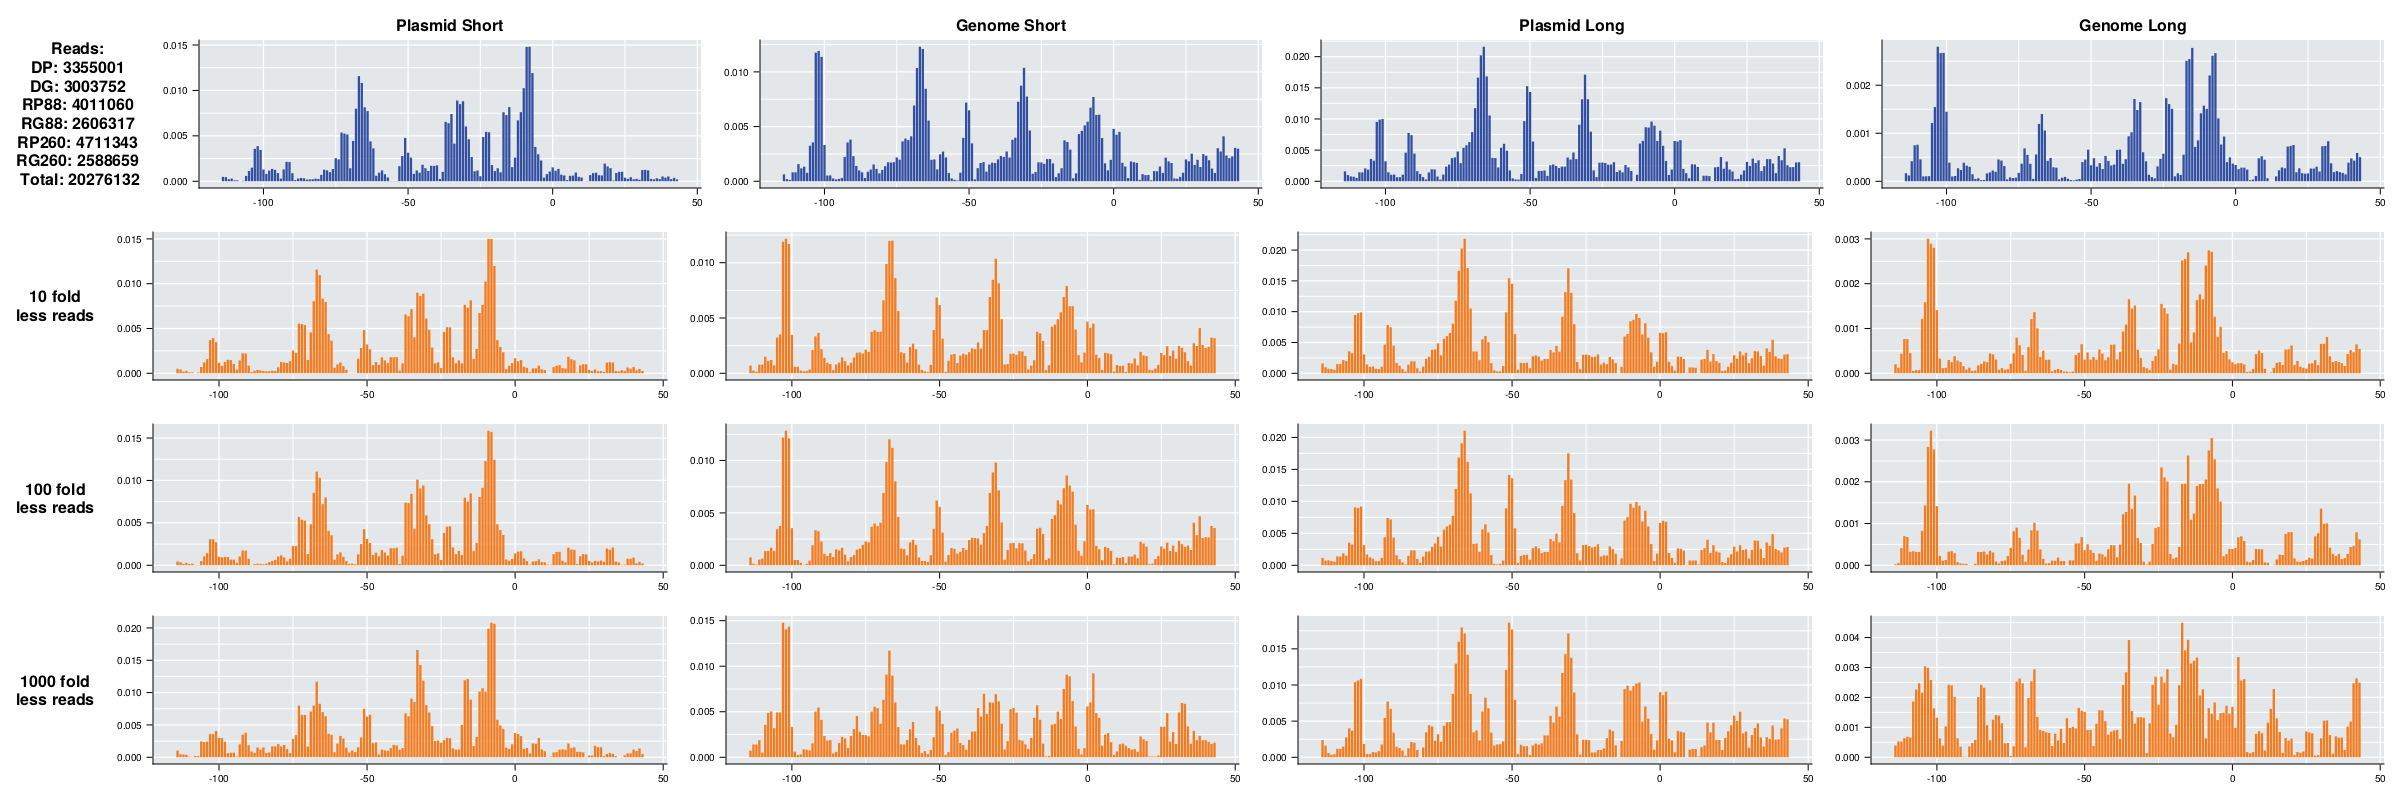

In [ ]:
function plot_downsample(prom, d=1, alpha=1)
    fig = Figure(resolution=(2400, 800))
    g0 = fig[1, 1:5]
    g10 = fig[2, 1:5]
    g100 = fig[3, 1:5]
    g1000 = fig[4, 1:5]

    g_list = [g10, g100, g1000]

    for (j, shuff) in enumerate([10, 100, 1000])
        df_import = DataFrame()
        for ind in ["DP", "DG", "RP88", "RG88", "RP260", "RG260"]
            _df = CSV.read("../../../data/extracted_barcodes/20230327_barcode/$(ind)_collapsed_shuff_$(shuff).txt", DataFrame, ignorerepeated=true, delim=" ", header=["ct", "barcode"])
            insertcols!(_df, 1, :source => ind)
            append!(df_import, _df)
        end

        df_shuff = innerjoin(df_import, df_map, on=:barcode)

        p88_df_shuff = unstack(df_shuff[(df_shuff.source .== "DP") .| (df_shuff.source .== "RP88"), :], :source, :ct, fill=0)
        rename!(p88_df_shuff, Dict("DP" => "ct_0", "RP88" => "ct_1"))
        insertcols!(p88_df_shuff, 1, :ct => p88_df_shuff.ct_0 .+ p88_df_shuff.ct_1)

        p260_df_shuff = unstack(df_shuff[(df_shuff.source .== "DP") .| (df_shuff.source .== "RP260"), :], :source, :ct, fill=0)
        rename!(p260_df_shuff, Dict("DP" => "ct_0", "RP260" => "ct_1"))
        insertcols!(p260_df_shuff, 1, :ct => p260_df_shuff.ct_0 .+ p260_df_shuff.ct_1)

        g88_df_shuff = unstack(df_shuff[(df_shuff.source .== "DG") .| (df_shuff.source .== "RG88"), :], :source, :ct, fill=0)
        rename!(g88_df_shuff, Dict("DG" => "ct_0", "RG88" => "ct_1"))
        insertcols!(g88_df_shuff, 1, :ct => g88_df_shuff.ct_0 .+ g88_df_shuff.ct_1)

        g260_df_shuff = unstack(df_shuff[(df_shuff.source .== "DG") .| (df_shuff.source .== "RG260"), :], :source, :ct, fill=0)
        rename!(g260_df_shuff, Dict("DG" => "ct_0", "RG260" => "ct_1"))
        insertcols!(g260_df_shuff, 1, :ct => g260_df_shuff.ct_0 .+ g260_df_shuff.ct_1);
        
        Label(g_list[j][1, 1], "$(shuff) fold\nless reads",tellheight = false, font = :bold)

        for (i, (df_full, df_shuff)) in enumerate([(p88_df, p88_df_shuff), (g88_df, g88_df_shuff), (p260_df, p260_df_shuff), (g260_df, g260_df_shuff)])
            
            x_shuff = wgregseq.footprints.mutual_information_mutation(df_shuff[df_shuff.name .== prom, :])
            #x = wgregseq.footprints.mutual_information_mutation(df_full[df_full.name .== prom, :])

            if d != 0
                #x = [mean(x[j-d:j+d]) for j in 1+d:160-d]
                x_shuff = [mean(x_shuff[j-d:j+d]) for j in 1+d:160-d]
            end

            
            ax = Axis(g_list[j][1, i+1])
            

            #barplot!(ax, collect(-115+d:44-d), x, color=(colors_dict["blue1"], alpha))
            barplot!(ax, collect(-115+d:44-d), x_shuff, color=(colors_dict["orange1"], alpha))
        end
    end

    for (i, df_full) in enumerate([p88_df, g88_df, p260_df, g260_df])
            
        x = wgregseq.footprints.mutual_information_mutation(df_full[df_full.name .== prom, :])

        if d != 0
            x = [mean(x[j-d:j+d]) for j in 1+d:160-d]
        end

        
        ax = Axis(g0[1, i+1])

        barplot!(ax, collect(-115+d:44-d), x, color=(colors_dict["blue1"], alpha))
    end

    Label(g0[1, 2, Top()], "Plasmid Short", valign = :bottom,
    font = :bold,
    padding = (0, 0, 5, 0))


    Label(g0[1, 3, Top()], "Genome Short", valign = :bottom,
    font = :bold,
    padding = (0, 0, 5, 0))


    Label(g0[1, 4, Top()], "Plasmid Long", valign = :bottom,
    font = :bold,
    padding = (0, 0, 5, 0))


    Label(g0[1, 5, Top()], "Genome Long", valign = :bottom,
    font = :bold,
    padding = (0, 0, 5, 0))

    tot_counts = 0
    lab = "Reads:"
    for ind in ["DP", "DG", "RP88", "RG88", "RP260", "RG260"]
        _df = CSV.read("../../../data/extracted_barcodes/20230327_barcode/$(ind)_collapsed.txt", DataFrame, ignorerepeated=true, delim=" ", header=["ct", "barcode"])
        lab = lab * "\n$(ind): $(sum(_df.ct))"
        tot_counts += sum(_df.ct)
    end
    lab = lab * "\n Total: $(tot_counts)"

    Label(g0[1, 1], lab,tellheight = false, font = :bold)
    return fig
end


In [ ]:
save("rspAp_downsample.pdf", plot_downsample("rspAp"))

CairoMakie.Screen{PDF}


In [ ]:
save("znuCp_downsample.pdf", plot_downsample("znuCp"))

CairoMakie.Screen{PDF}


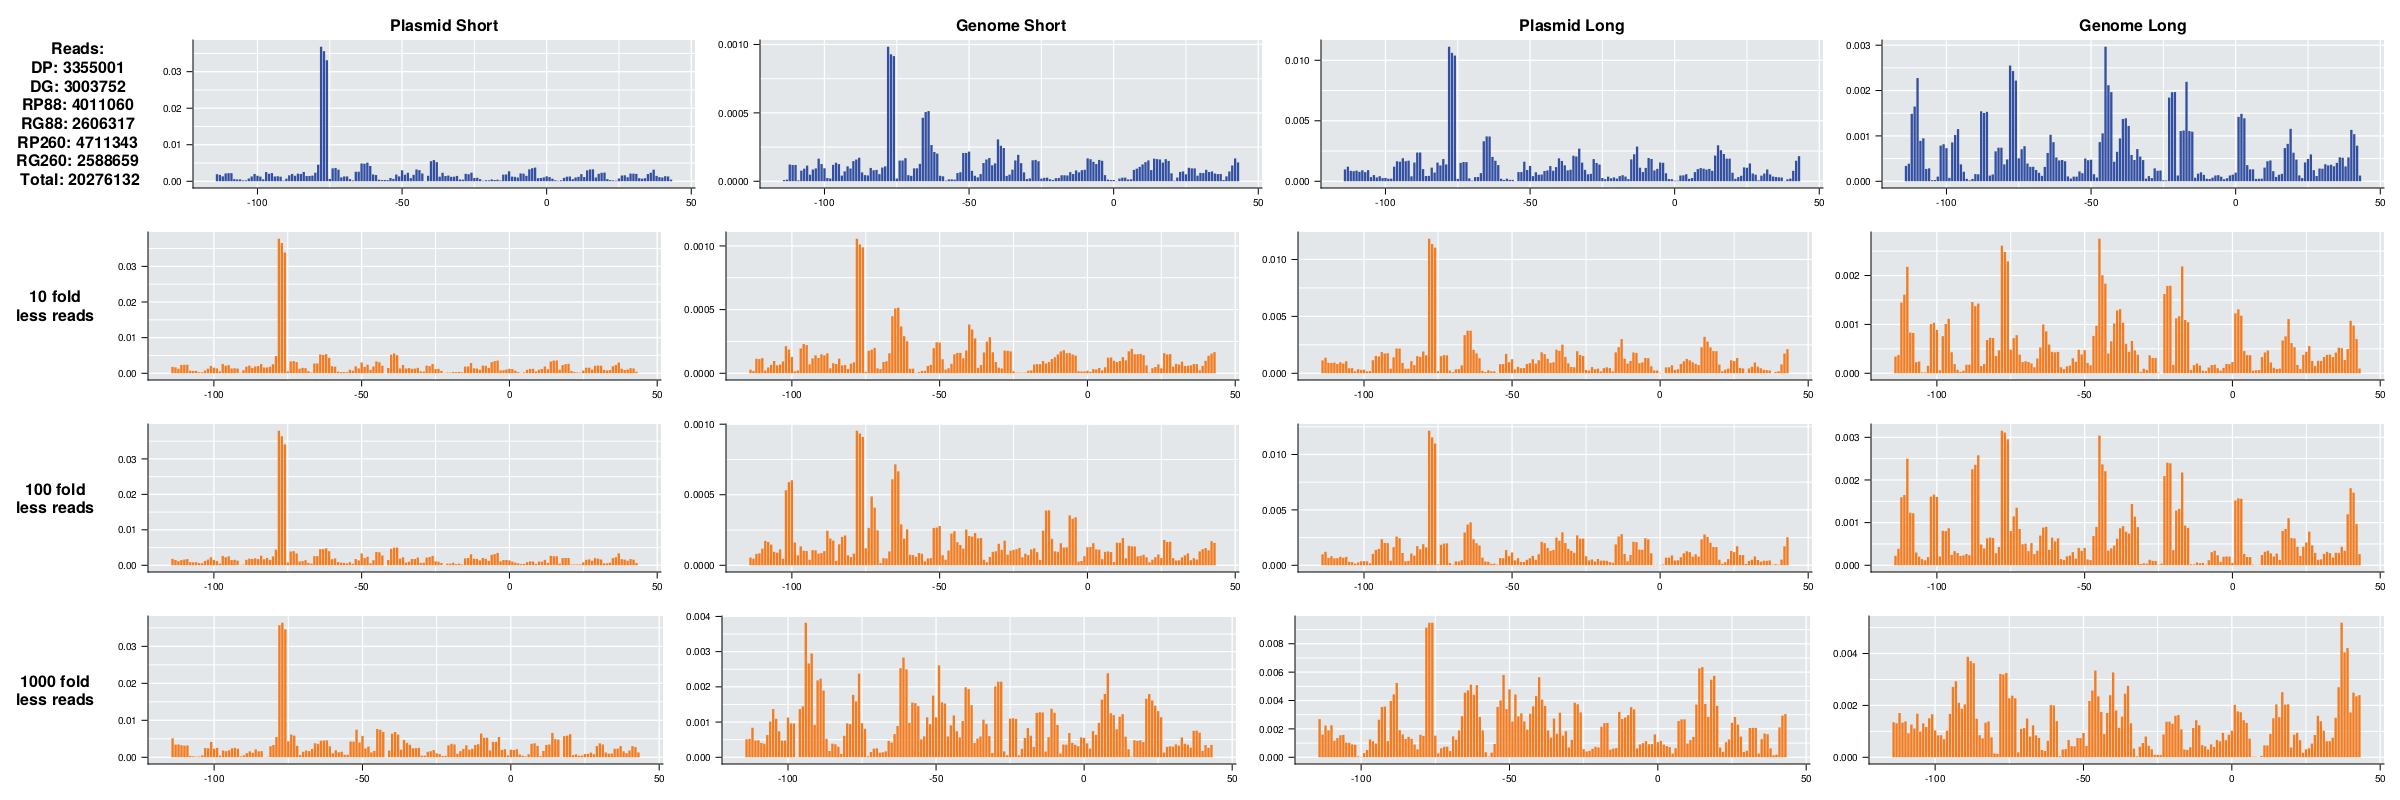

In [ ]:
plot_downsample("araBp")

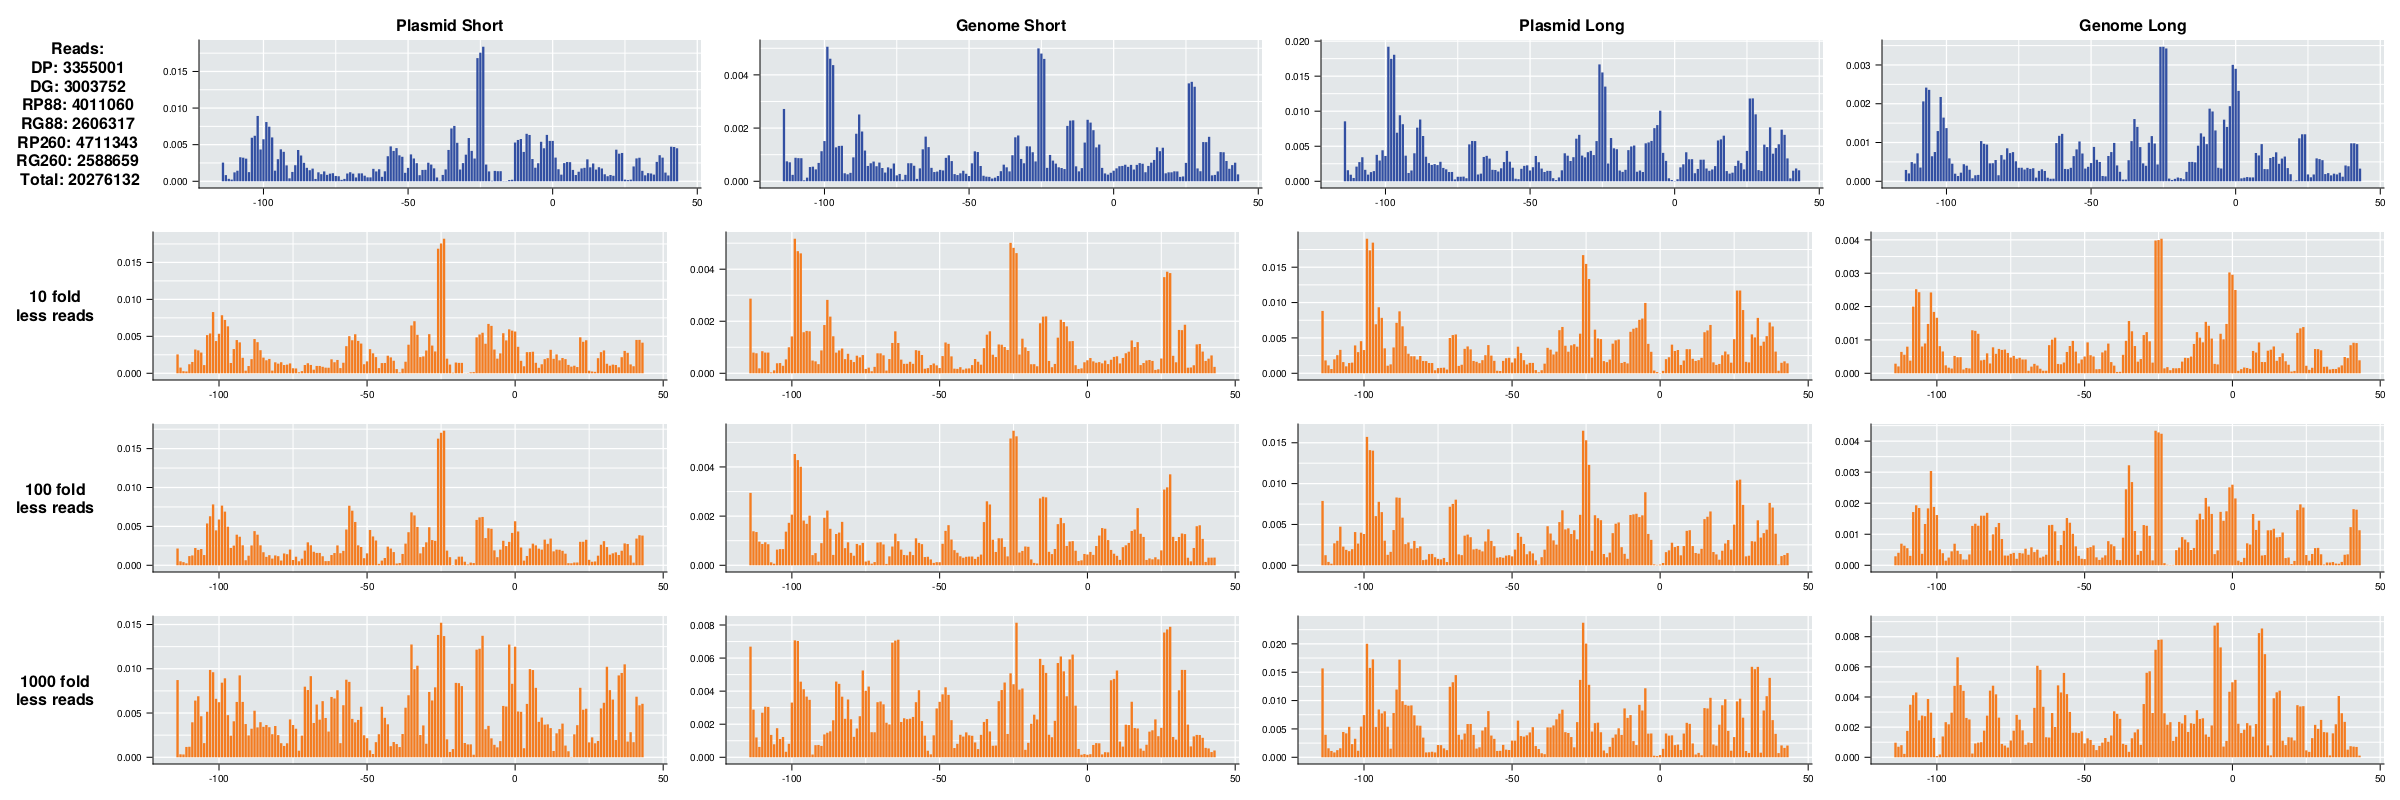

In [ ]:
plot_downsample("xylFp")

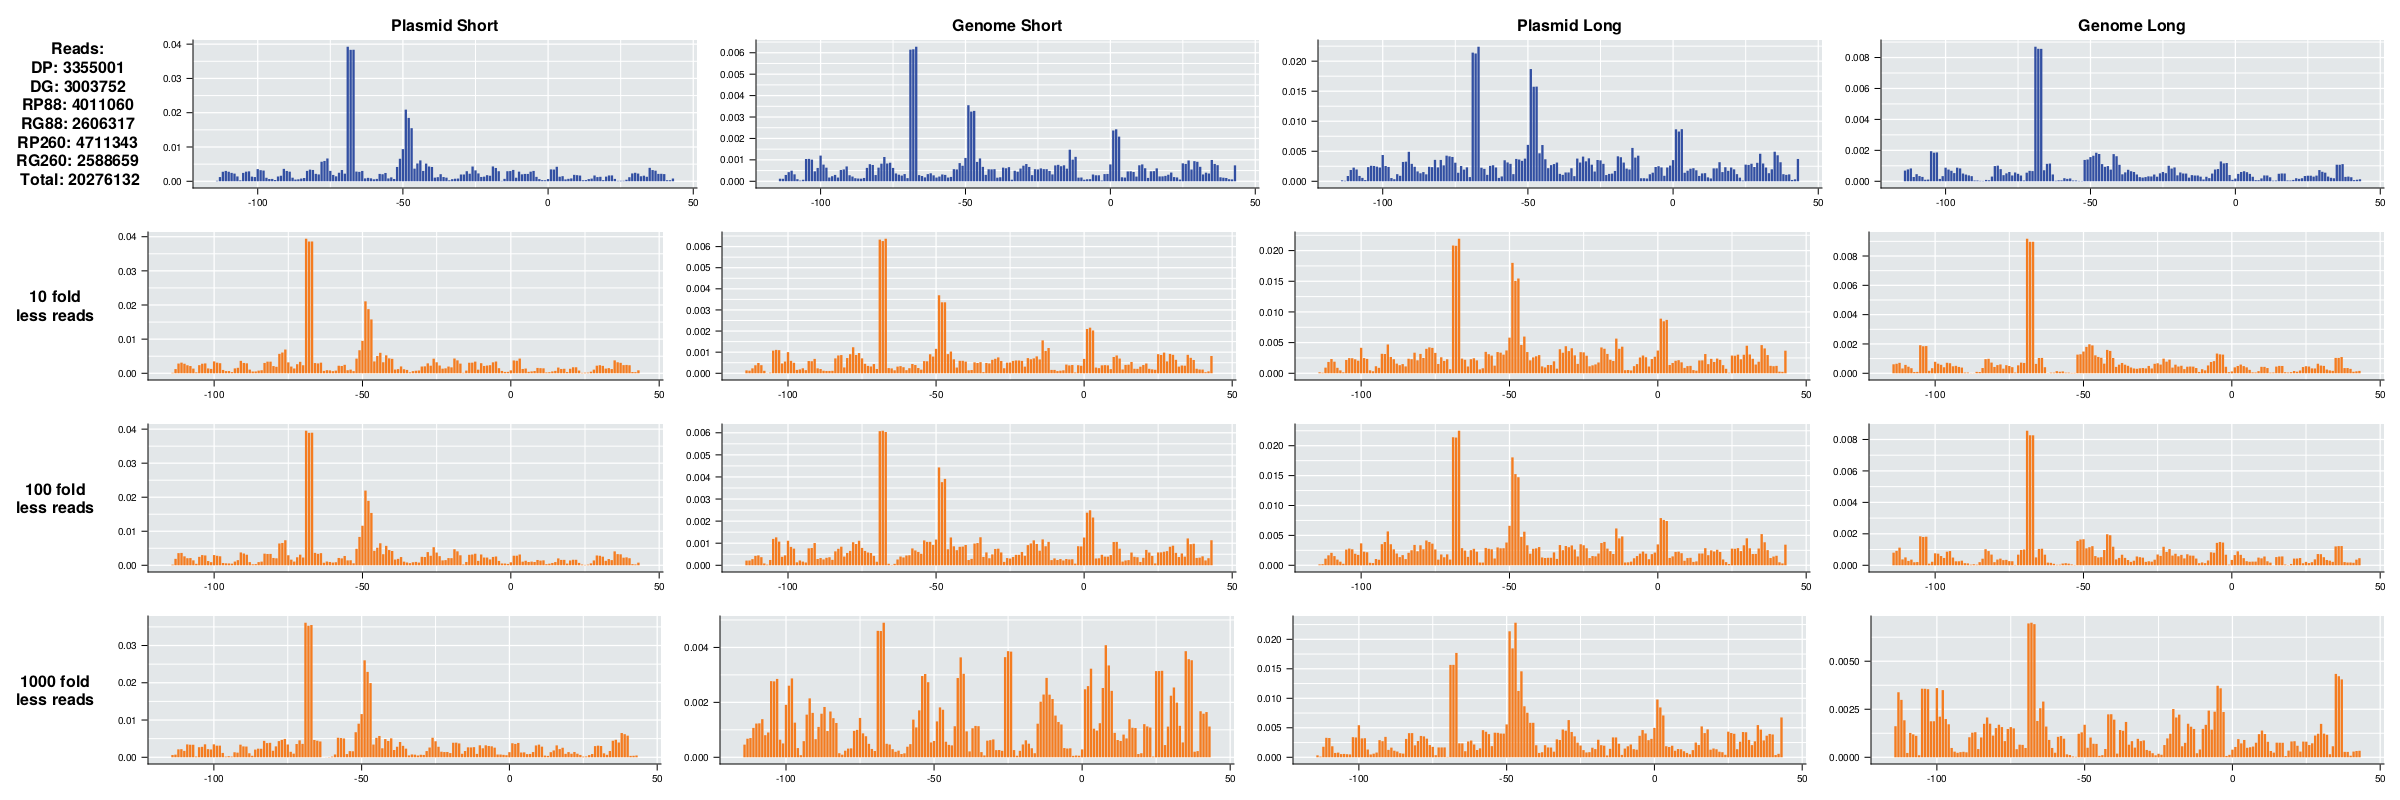

In [ ]:
plot_downsample("xylAp")

In [ ]:
CSV.read("../../../data/extracted_barcodes/20230327_barcode/RP88_collapsed_shuff_100.txt", DataFrame, ignorerepeated=true, delim=" ", header=["ct", "barcode"]).ct |> sum

40110

### Check downsampled data

### Genome

In [ ]:
s = 100

df_shuffle_DNA = CSV.read("../../../data/extracted_barcodes/20230327_barcode/DG_collapsed_shuff_$s.txt", DataFrame, ignorerepeated=true, delim=" ", header=["ct_0_shuff", "barcode"])

df_full_DNA = CSV.read("../../../data/extracted_barcodes/20230327_barcode/DG_collapsed.txt", DataFrame, ignorerepeated=true, delim=" ", header=["ct_0_full", "barcode"])

df_shuffle_RNA = CSV.read("../../../data/extracted_barcodes/20230327_barcode/RG88_collapsed_shuff_$s.txt", DataFrame, ignorerepeated=true, delim=" ", header=["ct_1_shuff", "barcode"])

df_full_RNA = CSV.read("../../../data/extracted_barcodes/20230327_barcode/RG88_collapsed.txt", DataFrame, ignorerepeated=true, delim=" ", header=["ct_1_full", "barcode"])

df = outerjoin(df_shuffle_DNA, df_shuffle_RNA, df_full_DNA, df_full_RNA, on=:barcode)
replace!(df.ct_0_full, missing => 0)
replace!(df.ct_1_full, missing => 0)
replace!(df.ct_0_shuff, missing => 0)
replace!(df.ct_1_shuff, missing => 0)
df = innerjoin(df, df_map, on=:barcode)

insertcols!(df, 1, :rel_ct_full => (df.ct_1_full .+ 1) ./ (df.ct_0_full .+ 1))
insertcols!(df, 1, :rel_ct_shuff => (df.ct_1_shuff .+ 1) ./ (df.ct_0_shuff .+ 1))


fig = Figure(resolution=(1200, 800))
g = fig[1, 1] = GridLayout()
g0 = fig[2, 1] = GridLayout()
g1 = fig[3, 1] = GridLayout()
ax1 = Axis(g0[1, 1])
ax2 = Axis(g0[1, 2])
ax3 = Axis(g0[1, 3])


scatter!(ax1, df.ct_0_full, df.ct_0_shuff, markersize=5)
r = cor(df.ct_0_full, df.ct_0_shuff)
ax1.title = string(round(r, digits=4))
ax1.xlabel = "DNA counts"
ax1.ylabel = "DNA counts downsampled"


scatter!(ax2, df.ct_1_full, df.ct_1_shuff, markersize=5)
r = cor(df.ct_1_full, df.ct_1_shuff)
ax2.title = string(round(r, digits=4))
ax2.xlabel = "RNA counts"
ax2.ylabel = "RNA counts downsampled"

scatter!(ax3, df.rel_ct_full, df.rel_ct_shuff, markersize=5)
r = cor(df.rel_ct_full, df.rel_ct_shuff)
ax3.title = string(round(r, digits=4))
ax3.xlabel = "relative counts"
ax3.ylabel = "relatve downsampled"

Label(g[1, 1:3, Top()], "Genome", valign=:bottom, tellheight=false, padding=(0, 0, 5, 0))


Label()

In [ ]:
df.ct_0_full |> sum |> println
df.ct_0_shuff |> sum |> println

2651615
26369


In [ ]:
df.ct_1_full |> sum |> println
df.ct_1_shuff |> sum |> println

3157327
31608


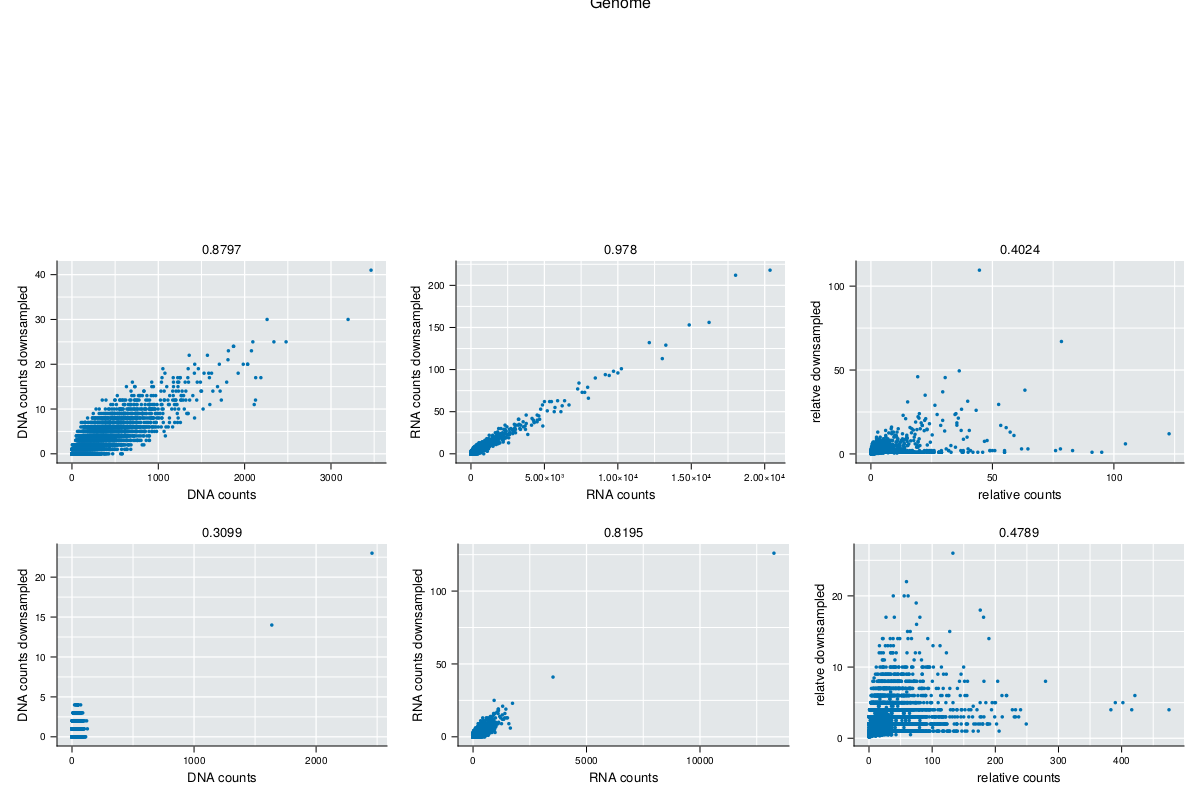

In [ ]:
df_shuffle_DNA = CSV.read("../../../data/extracted_barcodes/20230327_barcode/DP_collapsed_shuff_$s.txt", DataFrame, ignorerepeated=true, delim=" ", header=["ct_0_shuff", "barcode"])

df_full_DNA = CSV.read("../../../data/extracted_barcodes/20230327_barcode/DP_collapsed.txt", DataFrame, ignorerepeated=true, delim=" ", header=["ct_0_full", "barcode"])

df_shuffle_RNA = CSV.read("../../../data/extracted_barcodes/20230327_barcode/RP88_collapsed_shuff_$s.txt", DataFrame, ignorerepeated=true, delim=" ", header=["ct_1_shuff", "barcode"])

df_full_RNA = CSV.read("../../../data/extracted_barcodes/20230327_barcode/RP88_collapsed.txt", DataFrame, ignorerepeated=true, delim=" ", header=["ct_1_full", "barcode"])

df = outerjoin(df_shuffle_DNA, df_shuffle_RNA, df_full_DNA, df_full_RNA, on=:barcode)
replace!(df.ct_0_full, missing => 0)
replace!(df.ct_1_full, missing => 0)
replace!(df.ct_0_shuff, missing => 0)
replace!(df.ct_1_shuff, missing => 0)
df = innerjoin(df, df_map, on=:barcode)

insertcols!(df, 1, :rel_ct_full => (df.ct_1_full .+ 1) ./ (df.ct_0_full .+ 1))
insertcols!(df, 1, :rel_ct_shuff => (df.ct_1_shuff .+ 1) ./ (df.ct_0_shuff .+ 1))


ax1 = Axis(g1[1, 1])
ax2 = Axis(g1[1, 2])
ax3 = Axis(g1[1, 3])


scatter!(ax1, df.ct_0_full, df.ct_0_shuff, markersize=5)
r = cor(df.ct_0_full, df.ct_0_shuff)
ax1.title = string(round(r, digits=4))
ax1.xlabel = "DNA counts"
ax1.ylabel = "DNA counts downsampled"


scatter!(ax2, df.ct_1_full, df.ct_1_shuff, markersize=5)
r = cor(df.ct_1_full, df.ct_1_shuff)
ax2.title = string(round(r, digits=4))
ax2.xlabel = "RNA counts"
ax2.ylabel = "RNA counts downsampled"

scatter!(ax3, df.rel_ct_full, df.rel_ct_shuff, markersize=5)
r = cor(df.rel_ct_full, df.rel_ct_shuff)
ax3.title = string(round(r, digits=4))
ax3.xlabel = "relative counts"
ax3.ylabel = "relatve downsampled"

fig


In [ ]:
date
mcmc = CSV.read("footprints/" * date * "_" * ind * "_" * promoter * "_mcmc_mpathic_1_.csv", DataFrame)[!, ["val_A", "val_C", "val_G", "val_T"]] |> Matrix
prob_mat = exp.(mcmc) ./ sum(exp.(mcmc), dims=2)
x = sum(prob_mat .* log2.(prob_mat ./ 0.25), dims=2) |> vec

In [56]:
df_store = DataFrame()
for file in readdir("footprints")
    if split(file, '.')[end] == "csv"
        mcmc = CSV.read("footprints/" * file, DataFrame)[!, ["val_A", "val_C", "val_G", "val_T"]] |> Matrix
        prob_mat = exp.(mcmc) ./ sum(exp.(mcmc), dims=2)
        x = sum(prob_mat .* log2.(prob_mat ./ 0.25), dims=2) |> vec
        date = "2023_03_27"
        promoter = split(file, '_')[3]
        if split(file, '_')[2][1] == 'g'
            source = "genome"
        else
            source = "plasmid"
        end
        gc = "LB"
        replicate = "1"
        append!(df_store,
            DataFrame(date=date, promoter=promoter, source=source, footprint=x, growth_condition=gc, replicate=replicate, pos=collect(-115:44))
        )
    end
end
    

In [57]:
CSV.write("../../figures/20230327_footprints.csv", df_store)

"../../figures/20230327_footprints.csv"

In [ ]:
date
mcmc = CSV.read("footprints/" * date * "_" * ind * "_" * promoter * "_mcmc_mpathic_1_.csv", DataFrame)[!, ["val_A", "val_C", "val_G", "val_T"]] |> Matrix
prob_mat = exp.(mcmc) ./ sum(exp.(mcmc), dims=2)
x = sum(prob_mat .* log2.(prob_mat ./ 0.25), dims=2) |> vec